In [1]:
import pyNUISANCE as pn
import pyProSelecta as pps
import matplotlib.pyplot as plt


In [2]:

class comparison_guru:
    def __init__(self):
        self.rfact = pn.RecordFactory()
        self.input_source_mapping = {} # avoid dup inputs
        self.input_table_mapping = {} # map each input to table list
        self.table_comparisons = {} 

        self.labels = []
        self.tables = {}
        self.comparisons = {}
        self.entries = {}

        self.source_objects = {}
        self.source_mapping = {}
        self.source_weights = {}
        
        self.wfact = pn.WeightCalcFactory()
        self.dial_values = {}
        
    def add(self, yaml_obj, label=None):
        
        table = self.rfact.make_table( yaml_obj )
        if not label: label = table.metadata()["id"]
        
        self.labels.append(label)
        self.entries[label] = yaml_obj
        self.tables[label] = table
        self.comparisons[label] = table.comparison()

        filepath = yaml_obj["filepath"]
        if filepath not in self.source_objects:
            self.source_objects[filepath] = pn.EventSource(filepath)
            self.source_weights[filepath] = self.wfact.make(self.source_objects[filepath], {"neut_cardname": "neut.card"})
            self.source_mapping[filepath] = []

        self.source_mapping[filepath].append( [self.tables[label],self.comparisons[label]] )

    def set_parameter(self, dial, value):
        self.dial_values[dial] = value
        
    def add_hepdata(self, release, table, input_file):
        yaml_obj = {}
        yaml_obj["type"] = "hepdata"
        yaml_obj["filepath"] = input_file
        yaml_obj["release"] = release
        yaml_obj["table"] = table
        self.add(yaml_obj)
        
    def eval(self):

        for weighter in self.source_weights.values():
            weighter.set_parameters(self.dial_values)
            
        for tab, comp in zip(self.tables.values(), 
                             self.comparisons.values()):
            tab.clear(comp)

        for source, associations, weighter in zip(
            self.source_objects.values(),
            self.source_mapping.values(),
            self.source_weights.values()):

            count = 0
            for ev, cvw in source:  
                
                engine_weight = 1.0
                engine_weight *= weighter.calc_weight(ev)
                    
                for tab, comp in associations:
                    comp.mc.fill_if(tab.select(ev),
                                    tab.project(ev),
                                    cvw * engine_weight * tab.weight(ev))

                count += 1
                if count % 10000 == 0: print(count)
                if count > 100000: break
                    
            for tab, comp in associations:
                tab.finalize(comp, source.fatx()/source.sumw())
            
        chi2 = 0
        for tab, comp in zip(self.tables.values(), 
                             self.comparisons.values()):
            chi2 += tab.likelihood(comp)

        return chi2

    def plot(self):
        for comp in self.comparisons.values():
            plt.title(comp.metadata["id"])
            print(comp.data)
            comp.data.mpl().errorbar(label="Data", color='black', ls='none')
            comp.estimate.mpl().hist(color='green', alpha=0.5, label="MC")  
            plt.legend()
            plt.show()
            

In [3]:
# !cat /opt/neut/src/neutclass/NuXSecRES.h

In [ ]:
import pyNUISANCE as pn
import pyProSelecta as pps
import matplotlib.pyplot as plt
import numpy as np

filepath = "/Users/stowell/Downloads/T2KND_FHC_numu_C8H8_NEUT562_1M_0000.root"
src = pn.EventSource(filepath)
wfact = pn.WeightCalcFactory()

evs = pn.EventFrameGen(src, 10000)

def Q2_CC0PI(evt):
    mu = pps.sel.OutPartHM(evt, pps.pdg.kMuon)
    nu = pps.sel.Beam(evt, pps.pdg.kNuMu)
    pi = pps.sel.OutPartHM(evt, pps.pdg.kPiPlus)
    if not pi: pi = pps.sel.OutPartHM(evt, pps.pdg.kPiMinus)
    if not pi: pi = pps.sel.OutPartHM(evt, pps.pdg.kPiZero)
    if not mu or not nu or pi: return -999
    part = pps.proj.parts.Q2(nu,mu) / pps.units.GeV / pps.units.GeV 
    return part

def Q2_CC1PIP(evt):
    mu = pps.sel.OutPartHM(evt, pps.pdg.kMuon)
    nu = pps.sel.Beam(evt, pps.pdg.kNuMu)
    pip = pps.sel.OutPartHM(evt, pps.pdg.kPiPlus)
    pim = pps.sel.OutPartHM(evt, pps.pdg.kPiMinus)
    pi0 = pps.sel.OutPartHM(evt, pps.pdg.kPiZero)
    if not mu or not nu or not pip or pim or pi0: return -999
    part = pps.proj.parts.Q2(nu,mu) / pps.units.GeV / pps.units.GeV 
    return part

for MaRES in np.linspace(-3,3,5):
    wcalc = wfact.make(src, {"neut_cardname": "neut.card"})
    wcalc.set_parameters({"MaRES": 0.95 + 0.15*MaRES, "CA5RES": 1.01})
    evs.add_column(f"MaRES={MaRES}sig", wcalc)

for CA5RES in np.linspace(-3,3,5):
    wcalc = wfact.make(src, {"neut_cardname": "neut.card"})
    wcalc.set_parameters({"MaRES": 0.95, "CA5RES": 1.01+0.15*CA5RES})
    evs.add_column(f"CA5RES={CA5RES}sig", wcalc)
    
evs.add_column("Q2_CC0PI", Q2_CC0PI)
evs.add_column("Q2_CC1PIP", Q2_CC1PIP)
evs.progress(1000)
df = evs.all()
print(df)


[WeightCalc:warning]: GENIEReWeightCalc: Passed in IEventSourcePtr not instance of GHEP3EventSource.
LLOADING
Initializing with neut.card
 CRSPATH_ENV: /opt/neut/git_master/share/neut/crsdat
 Reading neut.card as card
 ======= CONFIGURATION FOR INTERACTIONS =======
 Reading neut.card as a card file
Reading bank: NEUT from card file: neut.card
Reading bank: NEUT from card file: neut.card
 Using Spectral Function for elastic events
 NECARD : INPUTTED PARAMETER 
 NECARD : CRSPATH= /opt/neut/git_master/share/neut/crsdat/
 NECARD : FERM   =            0
 NECARD : PAUL   =            0
 NECARD : PAUL2p2h =            0
 NECARD : NEFF   =            0
 NECARD : NUCDEXITE =            1
 NECARD : MODL   =            1
 NECARD : MODH   =            1
 NECARD : KINH   =            1
 NECARD : MODE   =            0
 NECARD : COHEPI =            2
 NECARD : DIFPI  =            0
 ********* CCQE SETTINGS ***************
 NECARD : MDLQE   =          402
 NECARD : MDLQEAF =            1
 NECARD : MDL

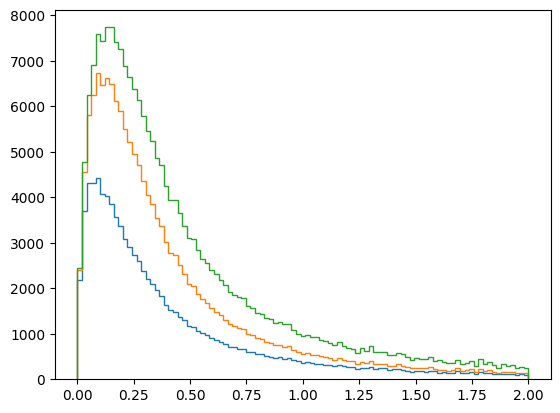

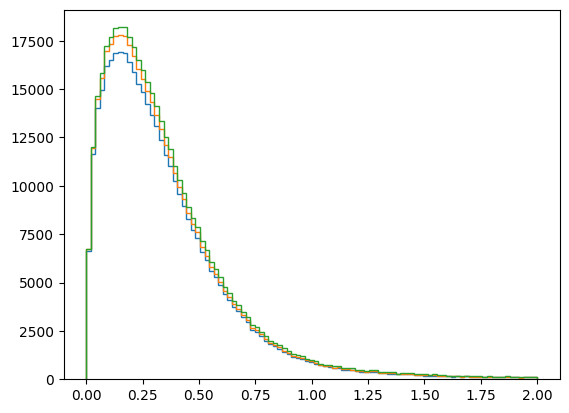

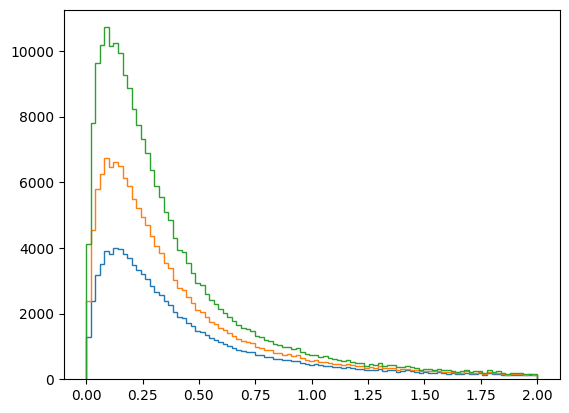

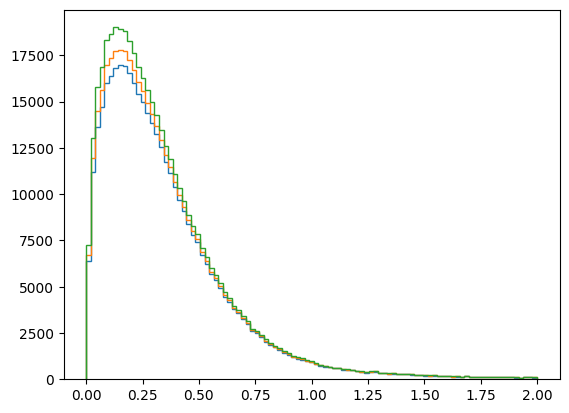

In [5]:
df.mpl().hist(x="Q2_CC1PIP", weights="MaRES=-3.0sig", bins=np.linspace(0,2,100), histtype='step')
df.mpl().hist(x="Q2_CC1PIP", weights="MaRES=0.0sig", bins=np.linspace(0,2,100), histtype='step')
df.mpl().hist(x="Q2_CC1PIP", weights="MaRES=3.0sig", bins=np.linspace(0,2,100), histtype='step')
plt.show()

df.mpl().hist(x="Q2_CC0PI", weights="MaRES=-3.0sig", bins=np.linspace(0,2,100), histtype='step')
df.mpl().hist(x="Q2_CC0PI", weights="MaRES=0.0sig", bins=np.linspace(0,2,100), histtype='step')
df.mpl().hist(x="Q2_CC0PI", weights="MaRES=3.0sig", bins=np.linspace(0,2,100), histtype='step')
plt.show()

df.mpl().hist(x="Q2_CC1PIP", weights="CA5RES=-3.0sig", bins=np.linspace(0,2,100), histtype='step')
df.mpl().hist(x="Q2_CC1PIP", weights="CA5RES=0.0sig", bins=np.linspace(0,2,100), histtype='step')
df.mpl().hist(x="Q2_CC1PIP", weights="CA5RES=3.0sig", bins=np.linspace(0,2,100), histtype='step')
plt.show()

df.mpl().hist(x="Q2_CC0PI", weights="CA5RES=-3.0sig", bins=np.linspace(0,2,100), histtype='step')
df.mpl().hist(x="Q2_CC0PI", weights="CA5RES=0.0sig", bins=np.linspace(0,2,100), histtype='step')
df.mpl().hist(x="Q2_CC0PI", weights="CA5RES=3.0sig", bins=np.linspace(0,2,100), histtype='step')
plt.show()

In [6]:
# import numpy as np
# chi2vals = []
# scanvals = np.linspace(-2,2,11)
# for val in scanvals:
#     cg.set_parameter("MaCCQE", val)
#     chi2vals.append(cg.eval())
#     print(chi2vals)
# import matplotlib.pyplot as plt
# plt.plot(scanvals, chi2vals)

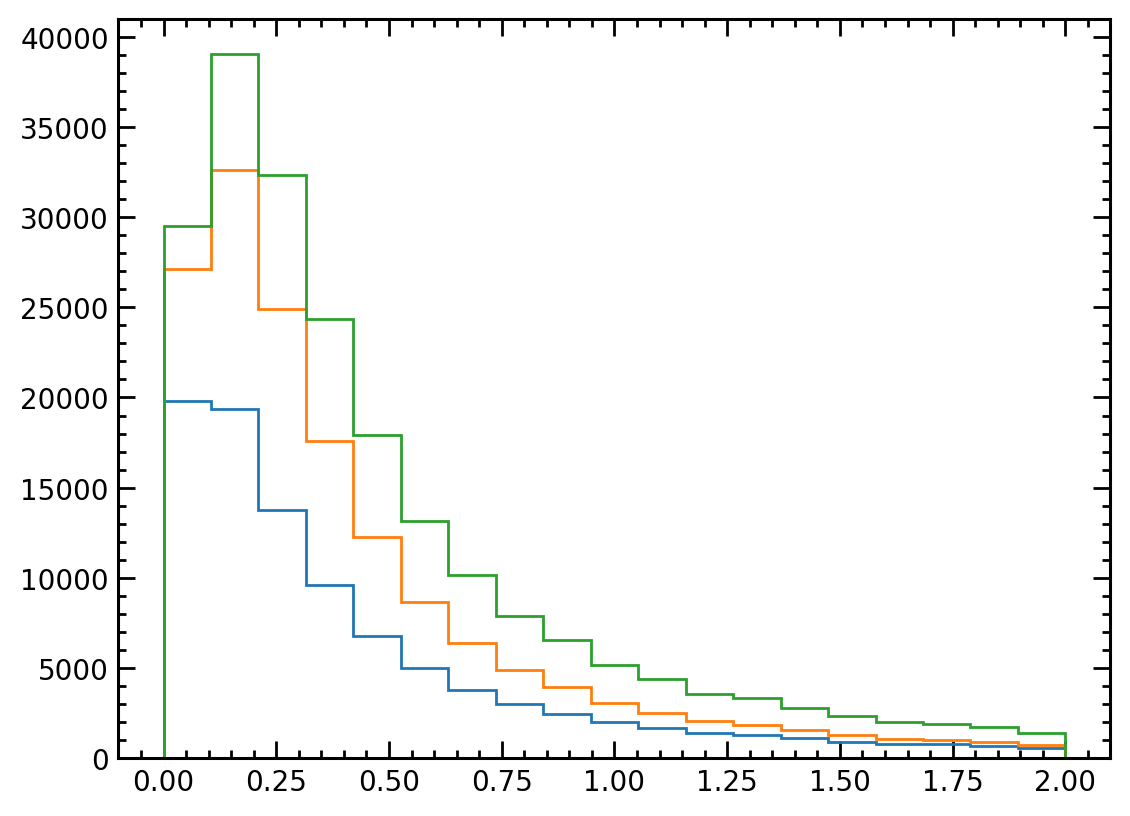

(19,) (20,) [<matplotlib.patches.Polygon object at 0x7fc65ad2b190>]


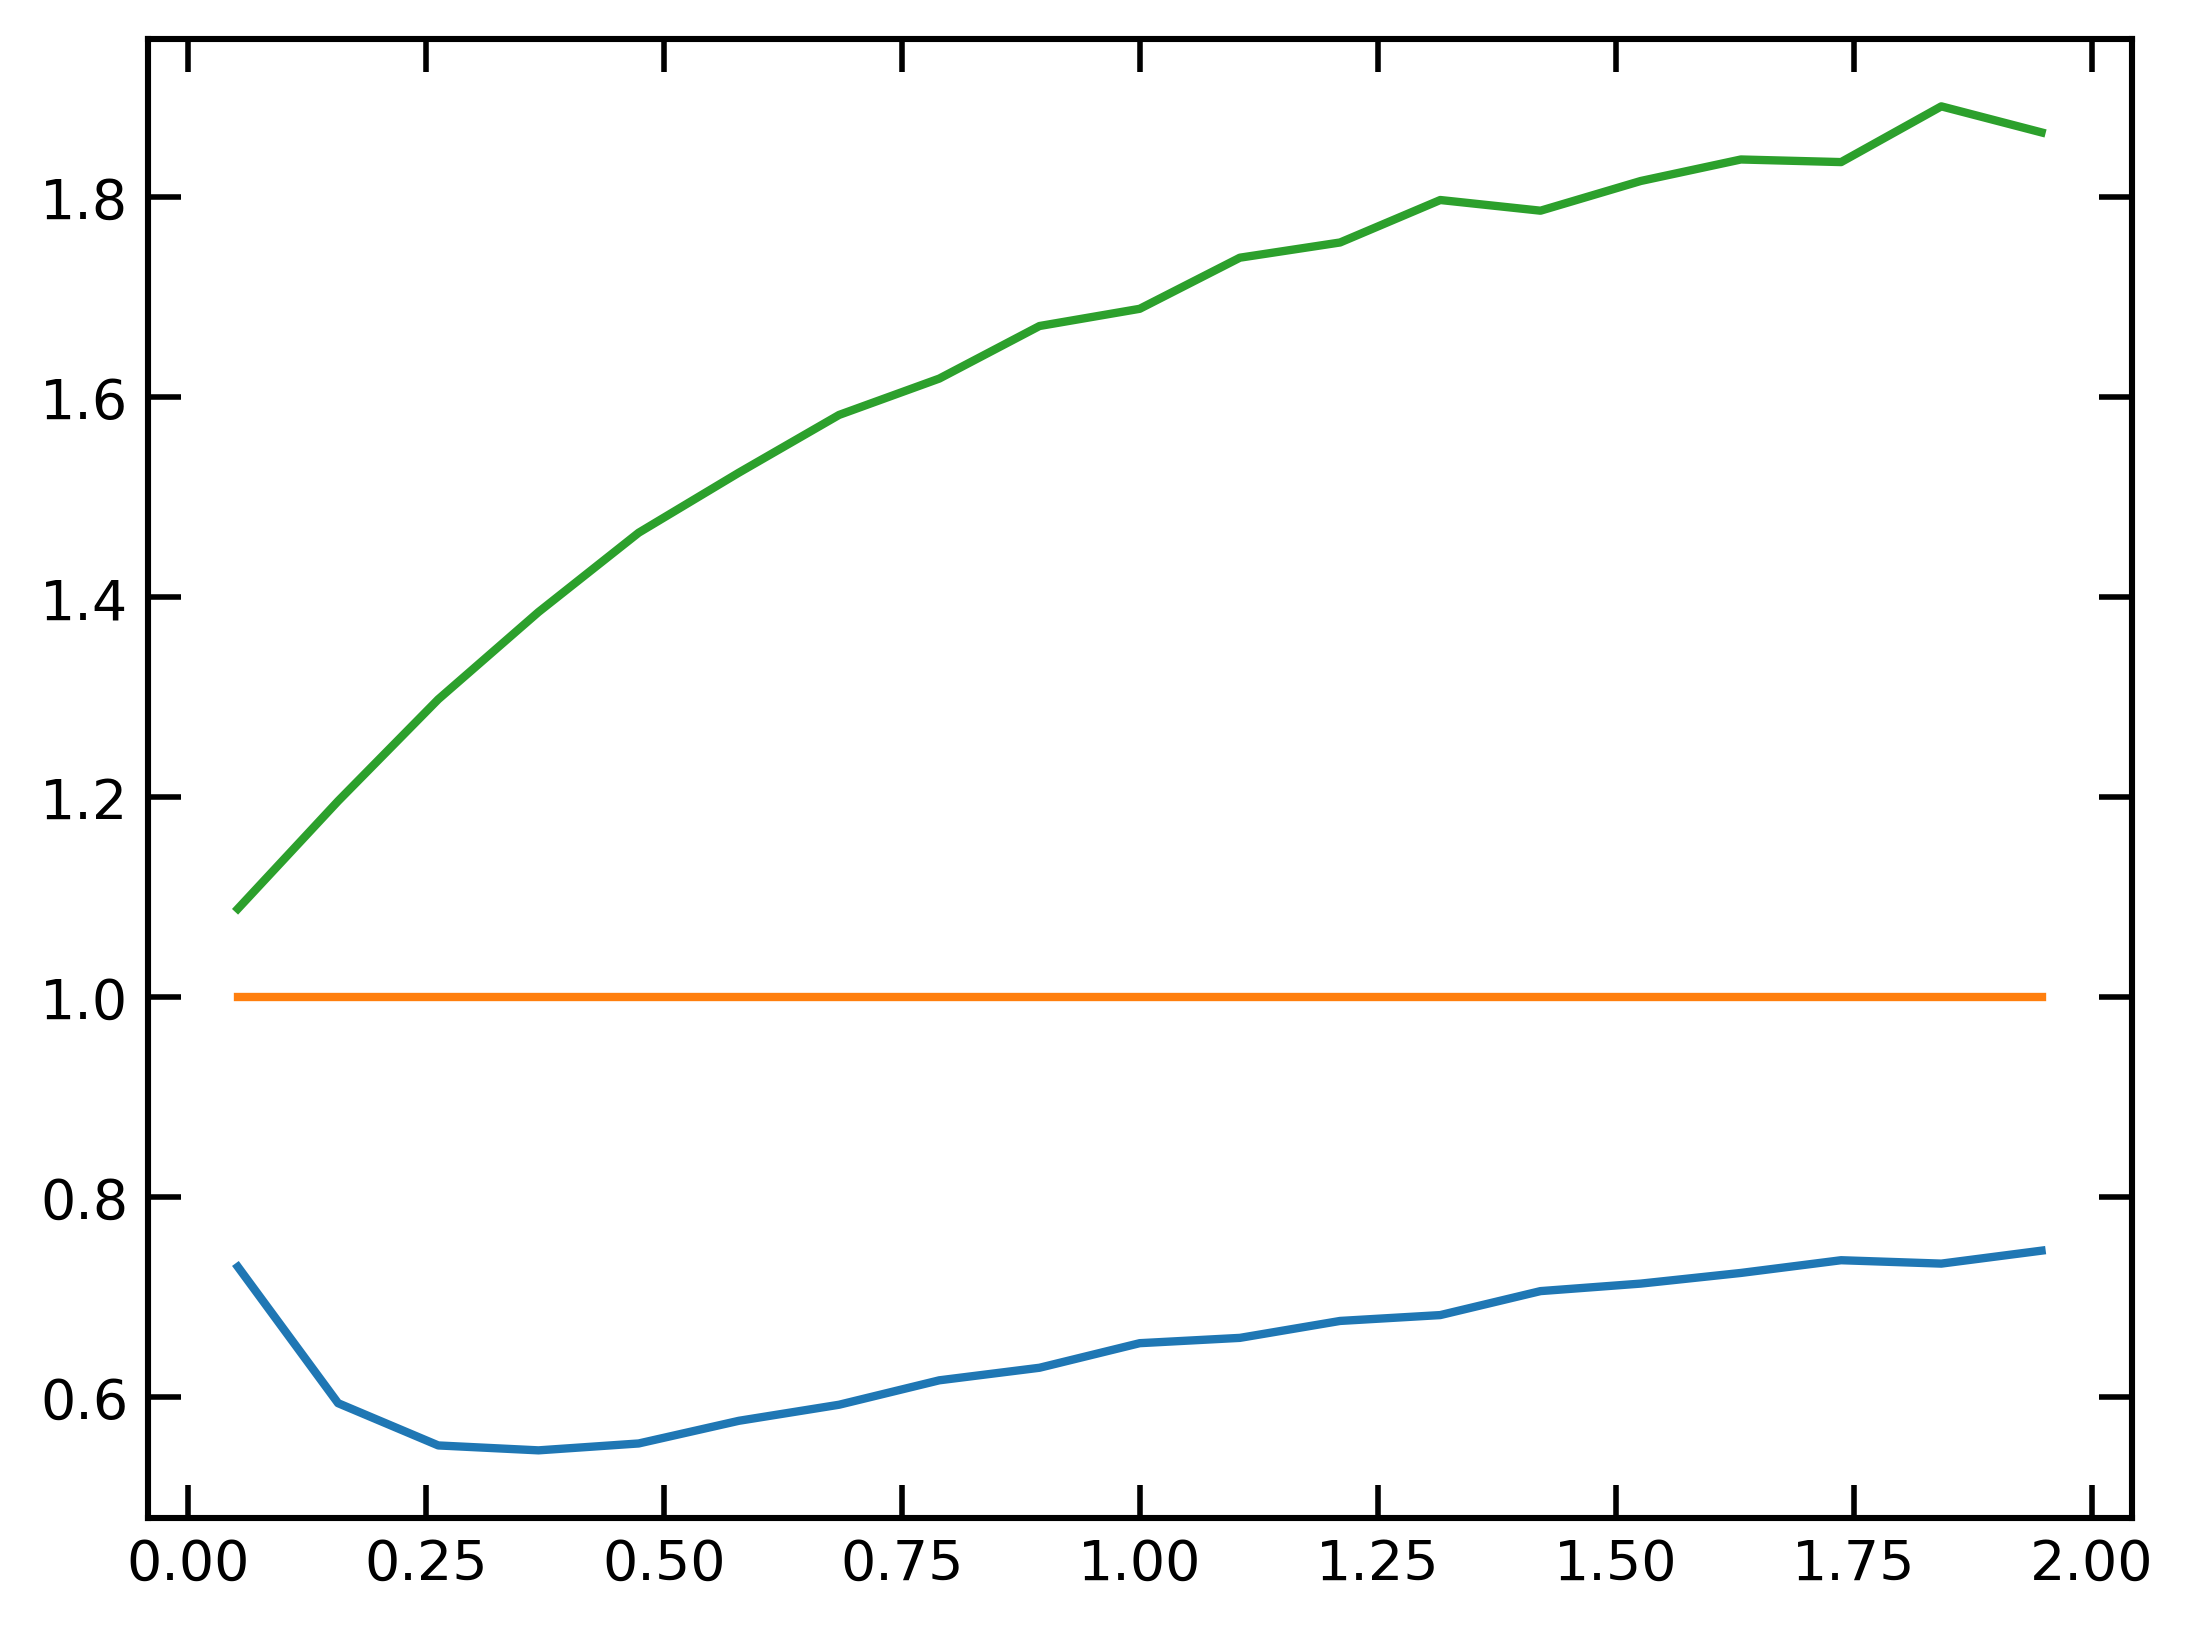

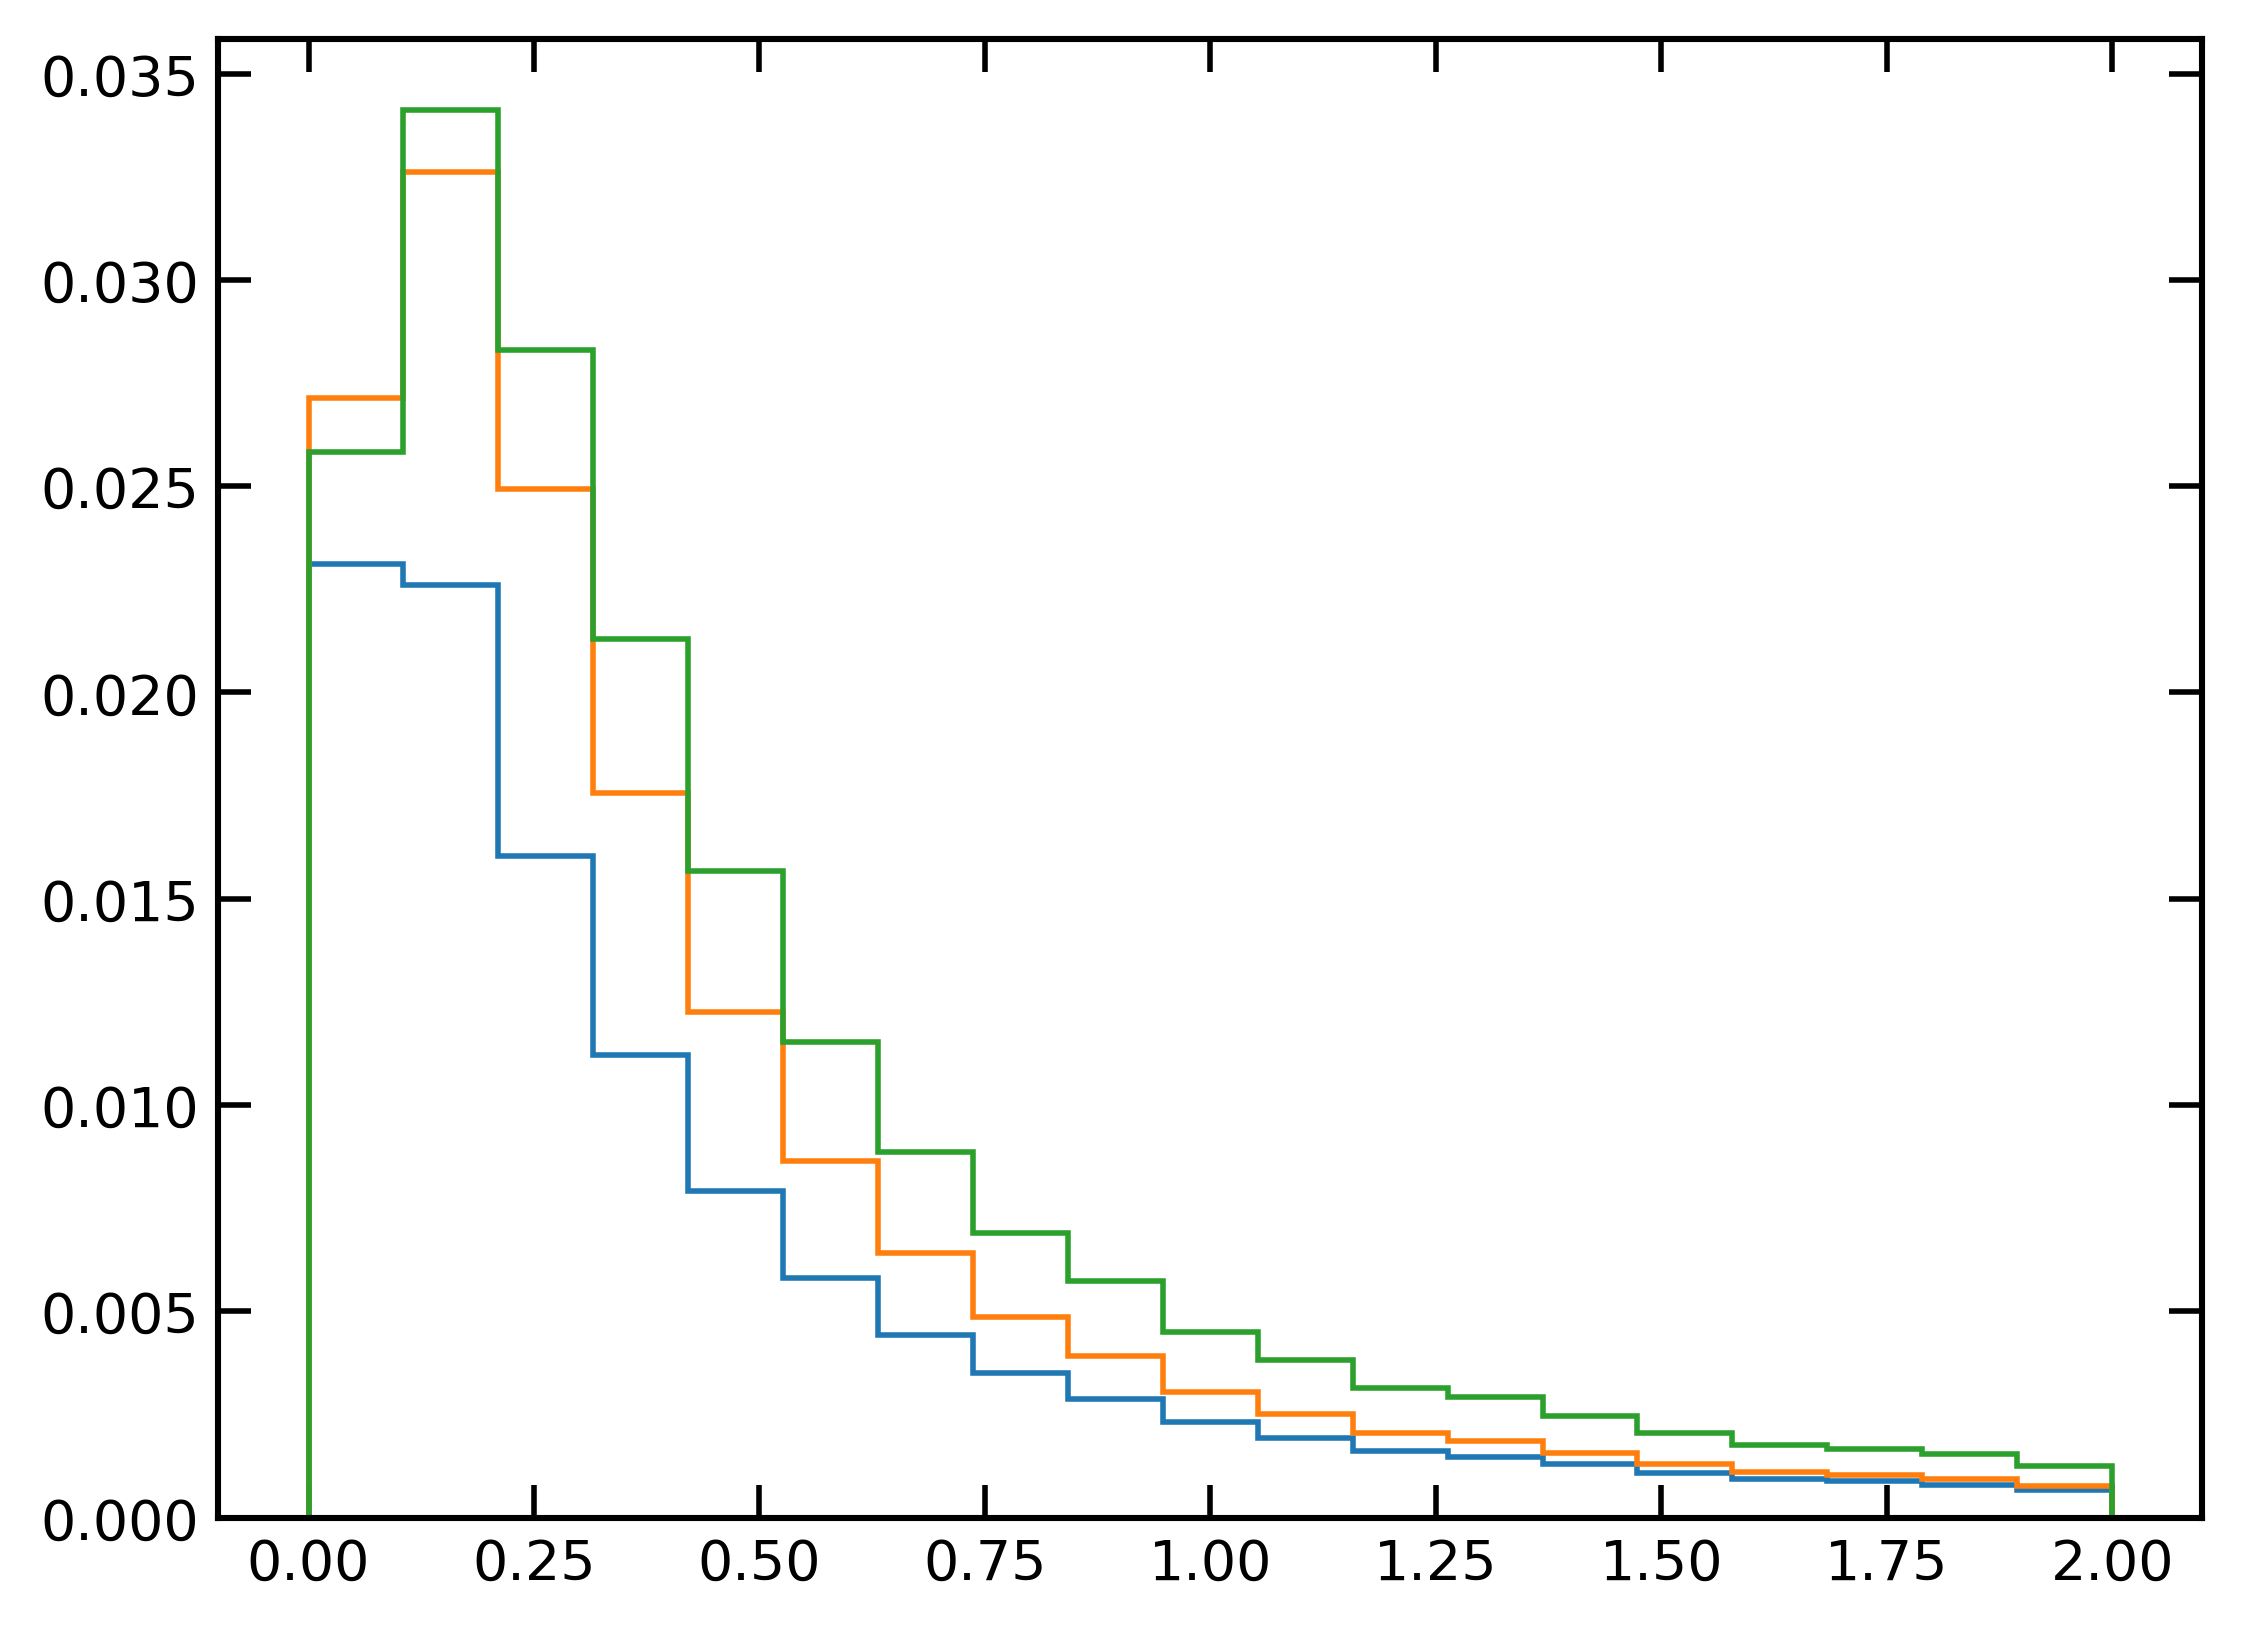

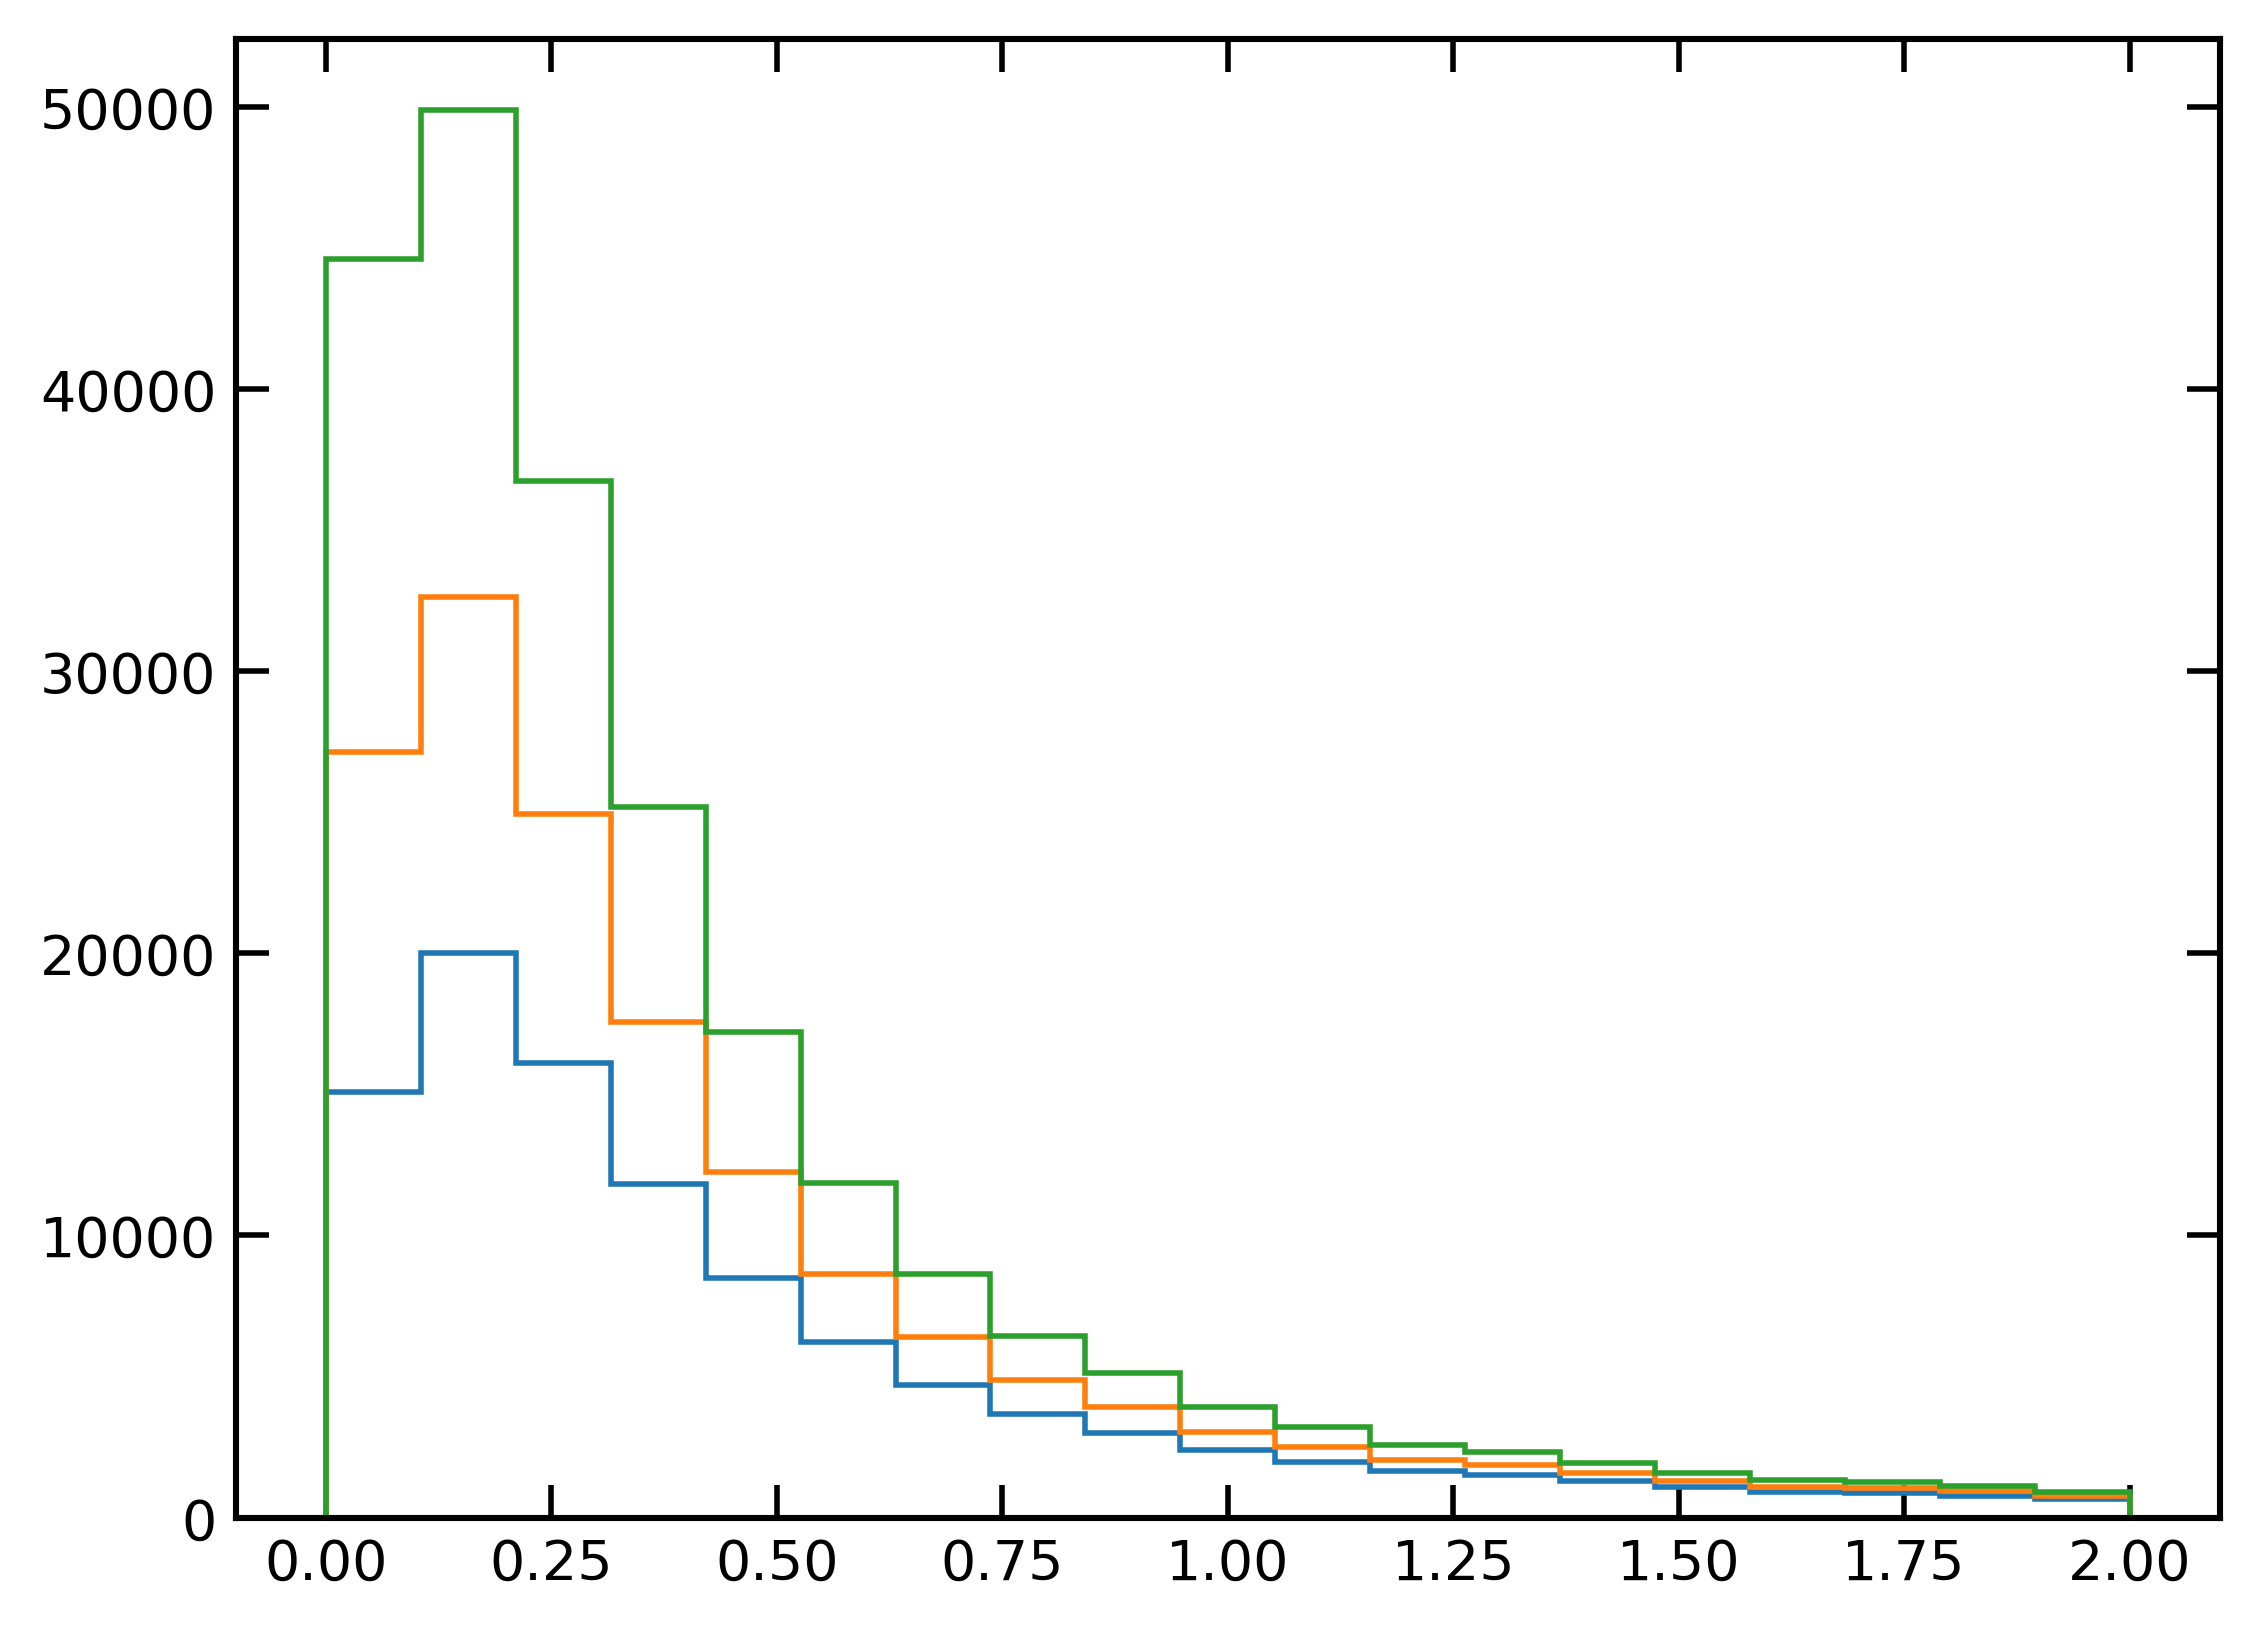

[15077.07274561 19993.25692105 16101.3980702  11825.37205649
  8495.89571718  6207.56509305  4709.62772552  3676.13814231
  3007.32628399  2388.20666102  1984.46011388  1633.85919549
  1494.23945619  1286.67401793  1068.31639224   909.4316223
   874.24424344   779.05657233   646.92708243]


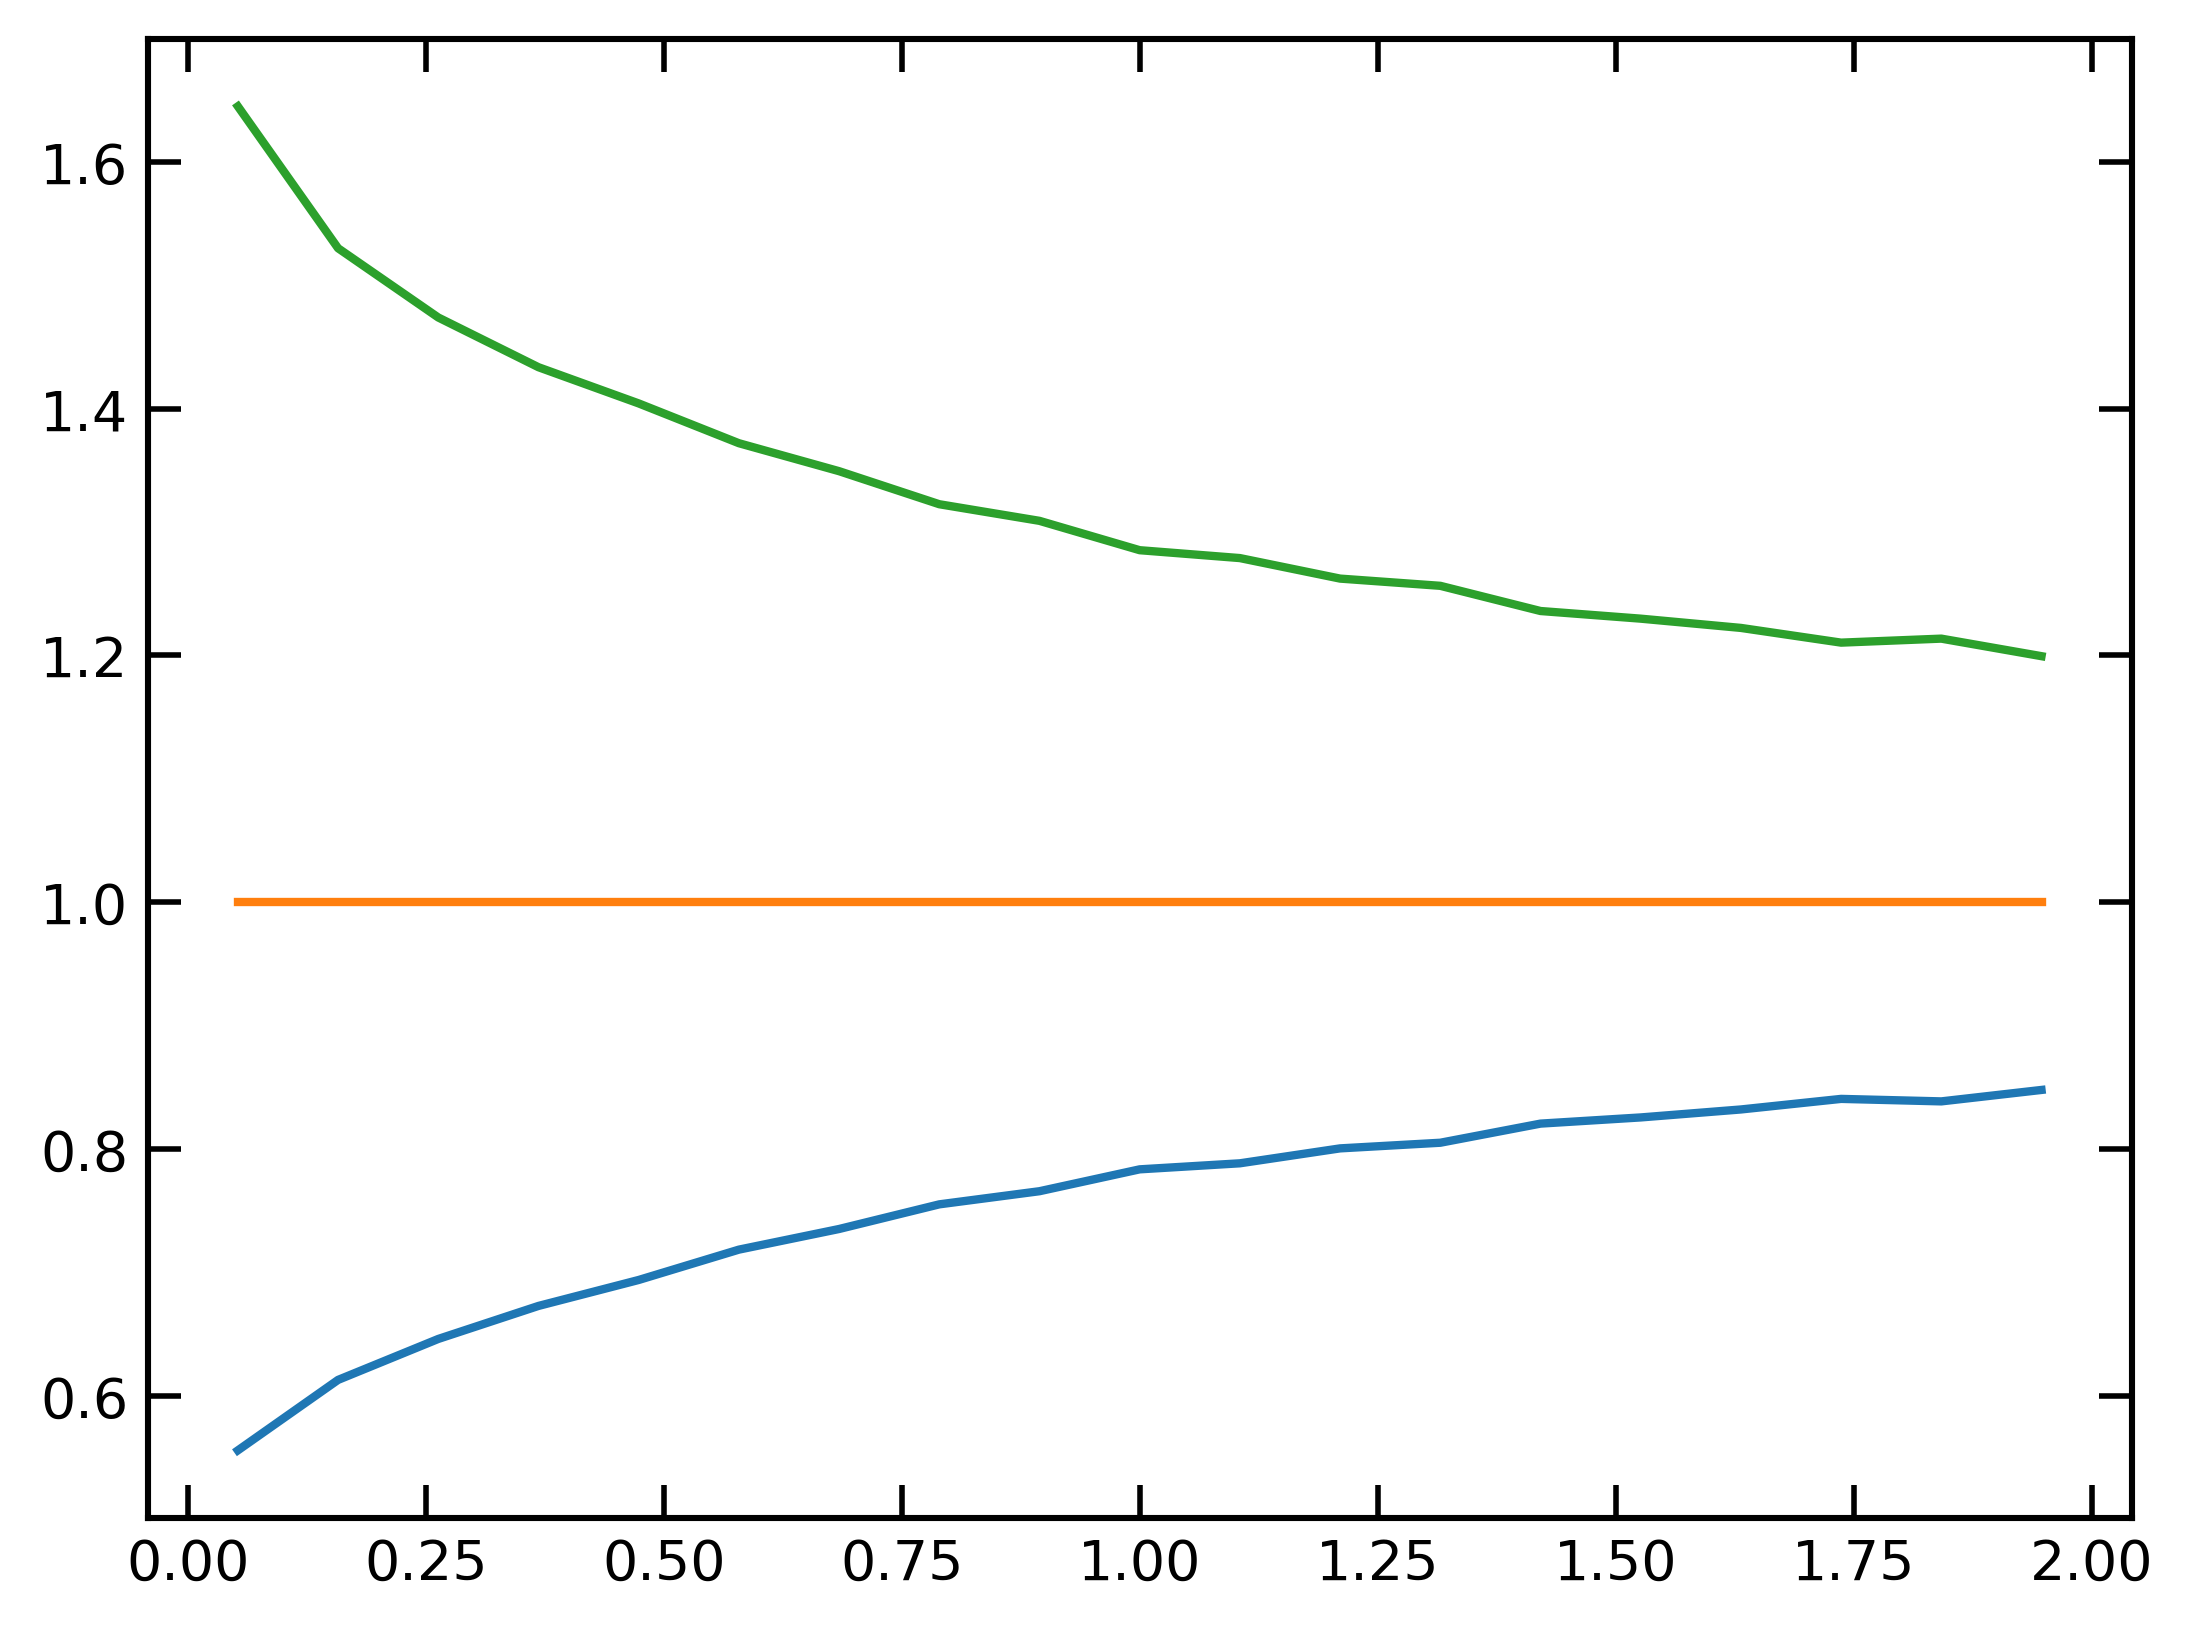

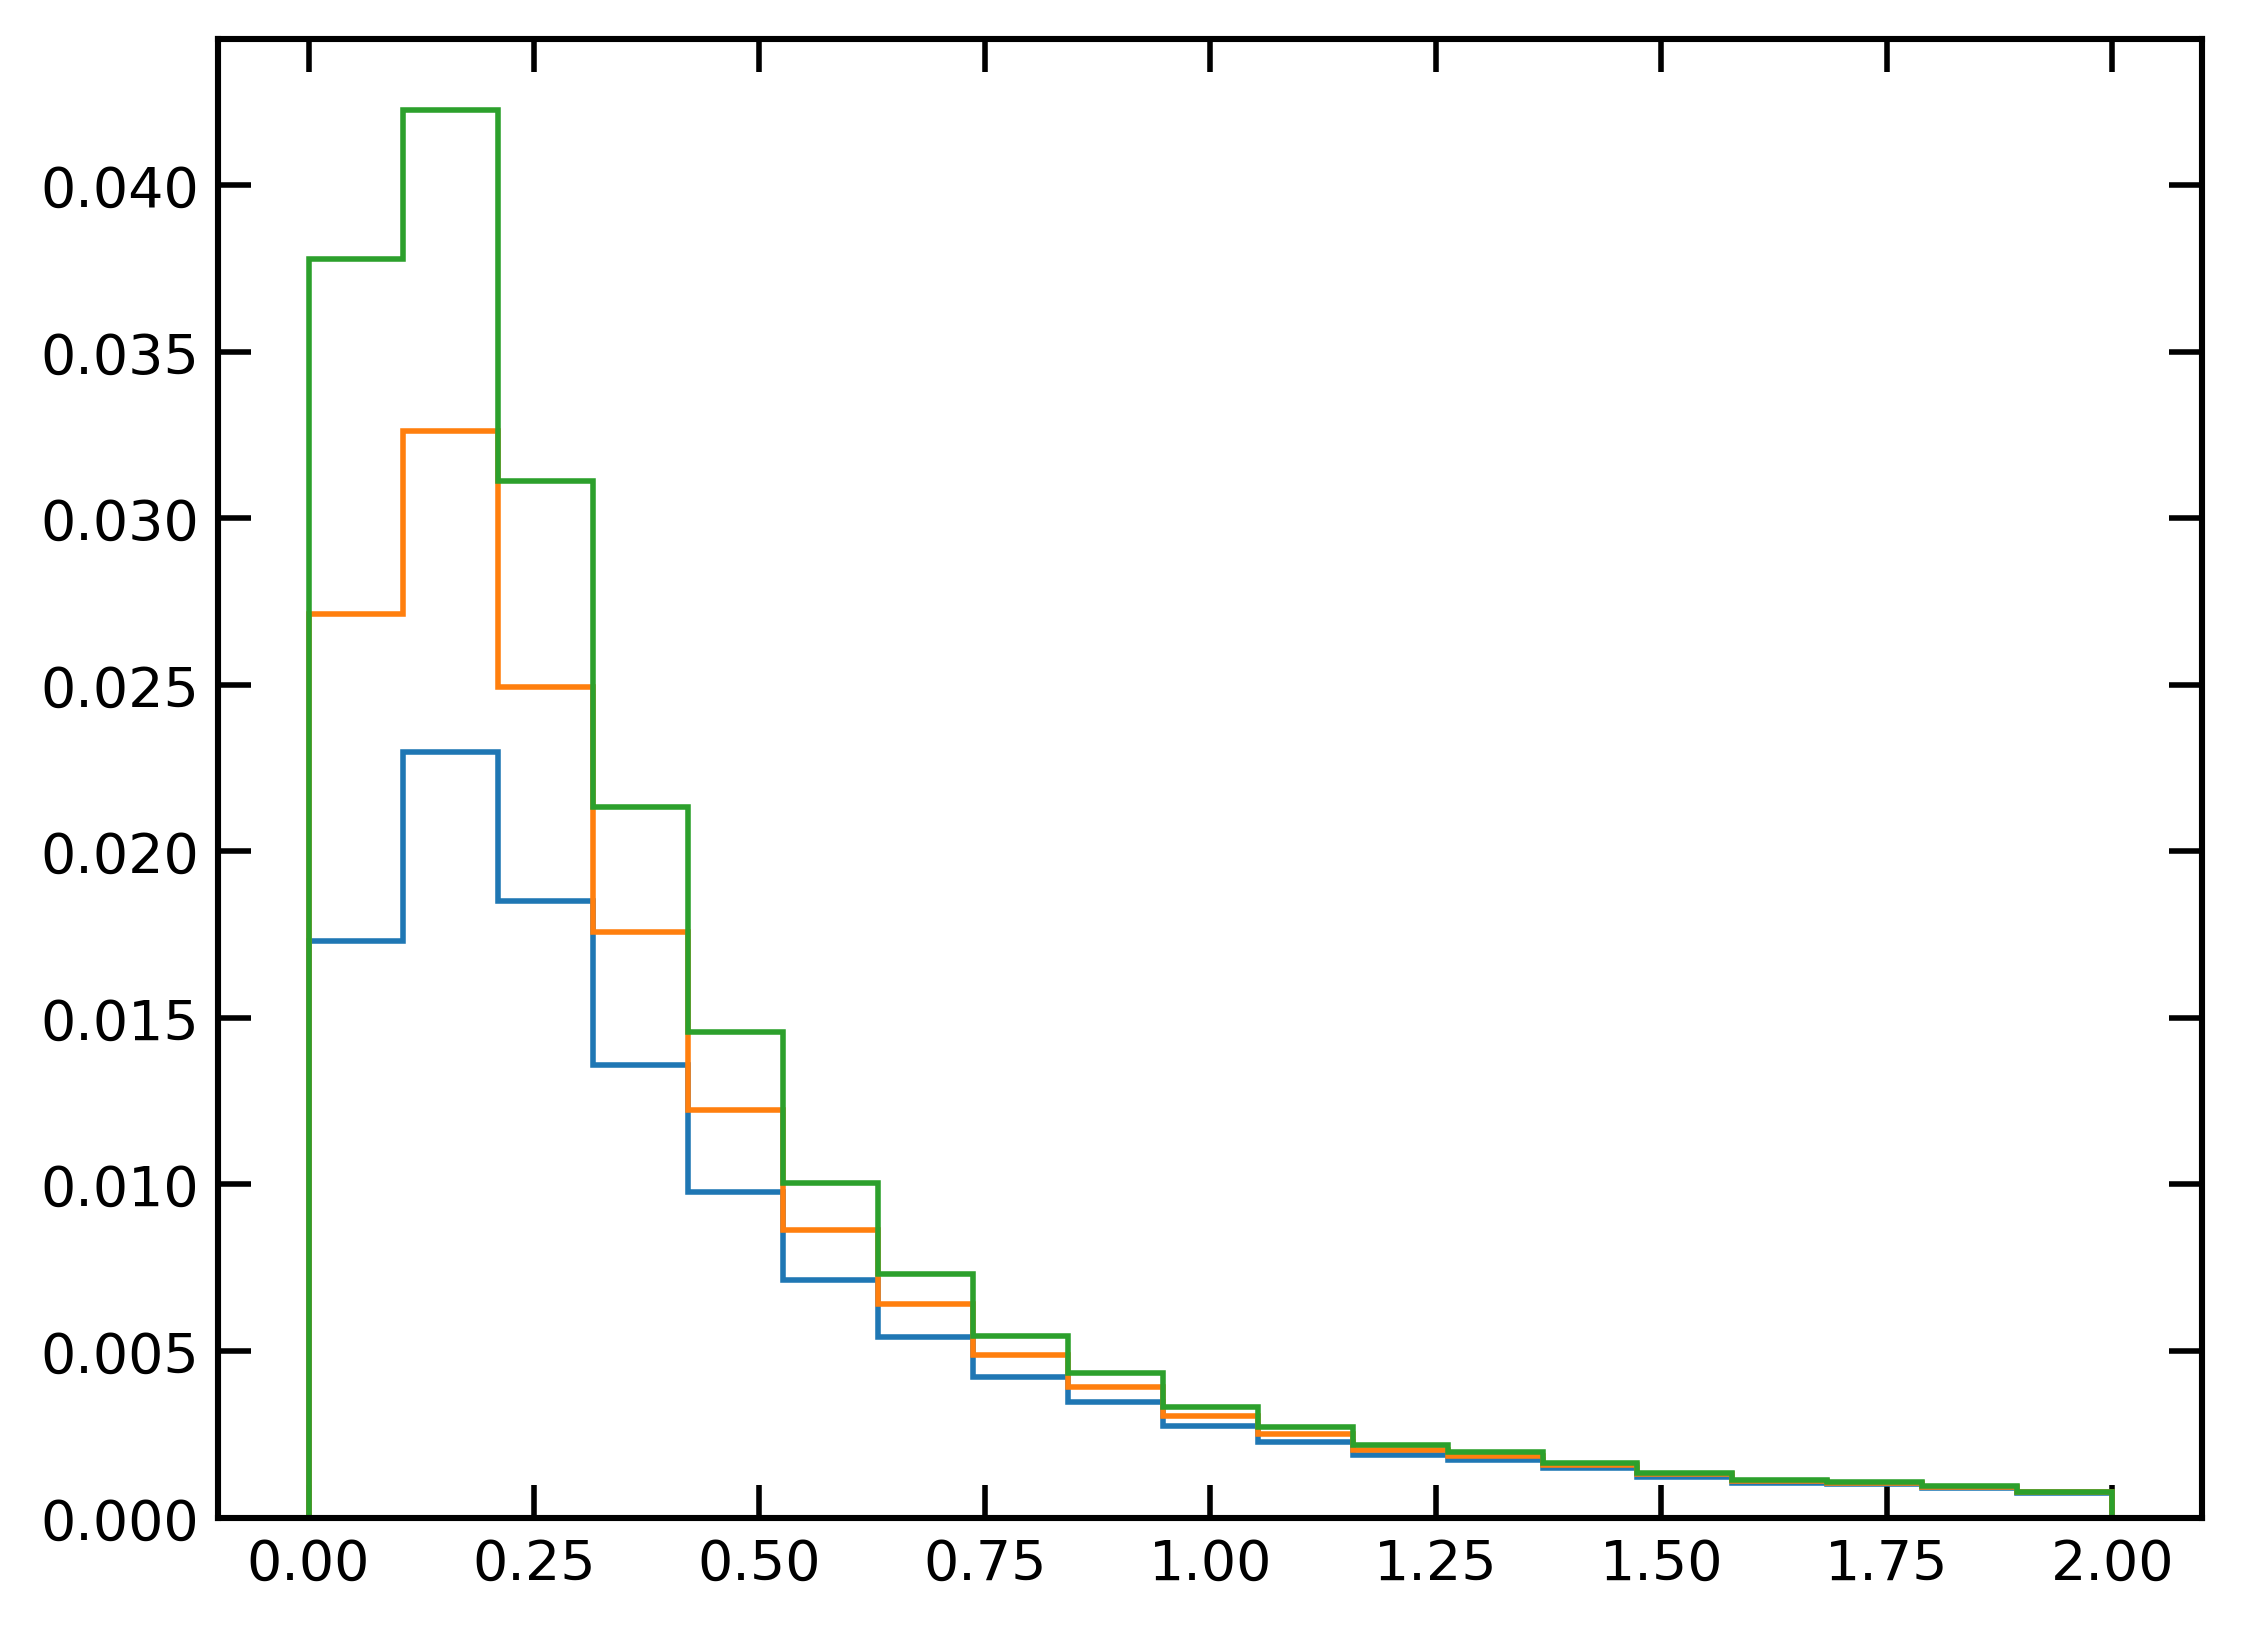

In [31]:
def set_cern_root_style():
    plt.minorticks_on()
    plt.rcParams.update({
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.top': True,
        'ytick.right': True,
        'xtick.major.size': 6,
        'ytick.major.size': 6,
        'xtick.minor.size': 3,
        'ytick.minor.size': 3,
        'xtick.major.width': 1,
        'ytick.major.width': 1,
        'xtick.minor.width': 1,
        'ytick.minor.width': 1,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'font.family': 'sans-serif',  # Set font family
        'font.serif': ['Times New Roman'],  # Set font to Times New Roman
        'axes.linewidth': 1.1,  # Increase axis linewidth for better visibility
        'axes.grid': False,  # Enable grid
        'axes.grid.which': 'major',  # Show both major and minor grid lines
        'axes.grid.axis': 'both',  # Show grid lines on both x and y axes
        'figure.dpi': 400,
        'legend.frameon': True,
        'legend.facecolor': 'none',  # Set legend background color
        'legend.edgecolor': 'none',  # Set legend border color to transparent
    })
set_cern_root_style()
binning_choice = np.linspace(0,2,20)
# binning_choice = [0.0,0.1,0.2,0.3,0.4,0.6,0.8,1.0,1.5,2.0]

bv_low, bins, binsc = df.mpl().hist(x="Q2_CC1PIP", weights="MaRES=-3.0sig", bins=binning_choice, histtype='step')
bv_mid, _, _ = df.mpl().hist(x="Q2_CC1PIP", weights="MaRES=0.0sig", bins=binning_choice, histtype='step')
bv_hig, _, _ = df.mpl().hist(x="Q2_CC1PIP", weights="MaRES=3.0sig", bins=binning_choice, histtype='step')
plt.show()

print(bv_low.shape, bins.shape, binsc)
plt.plot( (bins[0:-1] + bins[1:])/2, bv_low/bv_mid )
plt.plot( (bins[0:-1] + bins[1:])/2, bv_mid/bv_mid )
plt.plot( (bins[0:-1] + bins[1:])/2, bv_hig/bv_mid )
plt.show()

bv_low, _, _ = plt.hist(x=df["Q2_CC1PIP"], weights=df["MaRES=-3.0sig"]/np.sum(df["MaRES=-3.0sig"]), bins=binning_choice, histtype='step')
bv_mid, _, _ = plt.hist(x=df["Q2_CC1PIP"], weights=df["MaRES=0.0sig"]/np.sum(df["MaRES=0.0sig"]), bins=binning_choice, histtype='step')
bv_hig, _, _ = plt.hist(x=df["Q2_CC1PIP"], weights=df["MaRES=3.0sig"]/np.sum(df["MaRES=3.0sig"]), bins=binning_choice, histtype='step')
plt.show()

bv_low, _, _ = df.mpl().hist(x="Q2_CC1PIP", weights="CA5RES=-3.0sig", bins=binning_choice, histtype='step')
bv_mid, _, _ = df.mpl().hist(x="Q2_CC1PIP", weights="CA5RES=0.0sig", bins=binning_choice, histtype='step')
bv_hig, _, _ = df.mpl().hist(x="Q2_CC1PIP", weights="CA5RES=3.0sig", bins=binning_choice, histtype='step')
plt.show()

print(bv_low)

plt.plot( (bins[0:-1] + bins[1:])/2, bv_low/bv_mid )
plt.plot( (bins[0:-1] + bins[1:])/2, bv_mid/bv_mid )
plt.plot( (bins[0:-1] + bins[1:])/2, bv_hig/bv_mid )
plt.show()

plt.hist(x=df["Q2_CC1PIP"], weights=df["CA5RES=-3.0sig"]/np.sum(df["CA5RES=-3.0sig"]), bins=binning_choice, histtype='step')
plt.hist(x=df["Q2_CC1PIP"], weights=df["CA5RES=0.0sig"]/np.sum(df["CA5RES=0.0sig"]), bins=binning_choice, histtype='step')
plt.hist(x=df["Q2_CC1PIP"], weights=df["CA5RES=3.0sig"]/np.sum(df["CA5RES=3.0sig"]), bins=binning_choice, histtype='step')
plt.show()

# df.mpl().hist(x="Q2_CC1PIP", weights="CA5RES=0.75", bins=binning_choice, histtype='step')
# df.mpl().hist(x="Q2_CC1PIP", weights="CA5RES=0.875", bins=binning_choice, histtype='step')
# df.mpl().hist(x="Q2_CC1PIP", weights="CA5RES=1.0", bins=binning_choice, histtype='step')
# df.mpl().hist(x="Q2_CC1PIP", weights="CA5RES=1.125", bins=binning_choice, histtype='step')
# df.mpl().hist(x="Q2_CC1PIP", weights="CA5RES=1.25", bins=binning_choice, histtype='step')
# plt.show()

# plt.hist(x=df["Q2_CC1PIP"], weights=df["CA5RES=0.75"]/np.sum(df["CA5RES=0.75"]), bins=binning_choice, histtype='step')
# plt.hist(x=df["Q2_CC1PIP"], weights=df["CA5RES=0.875"]/np.sum(df["CA5RES=0.875"]), bins=binning_choice, histtype='step')
# plt.hist(x=df["Q2_CC1PIP"], weights=df["CA5RES=1.0"]/np.sum(df["CA5RES=1.0"]), bins=binning_choice, histtype='step')
# plt.hist(x=df["Q2_CC1PIP"], weights=df["CA5RES=1.125"]/np.sum(df["CA5RES=1.125"]), bins=binning_choice, histtype='step')
# plt.hist(x=df["Q2_CC1PIP"], weights=df["CA5RES=1.25"]/np.sum(df["CA5RES=1.25"]), bins=binning_choice, histtype='step')
# plt.show()

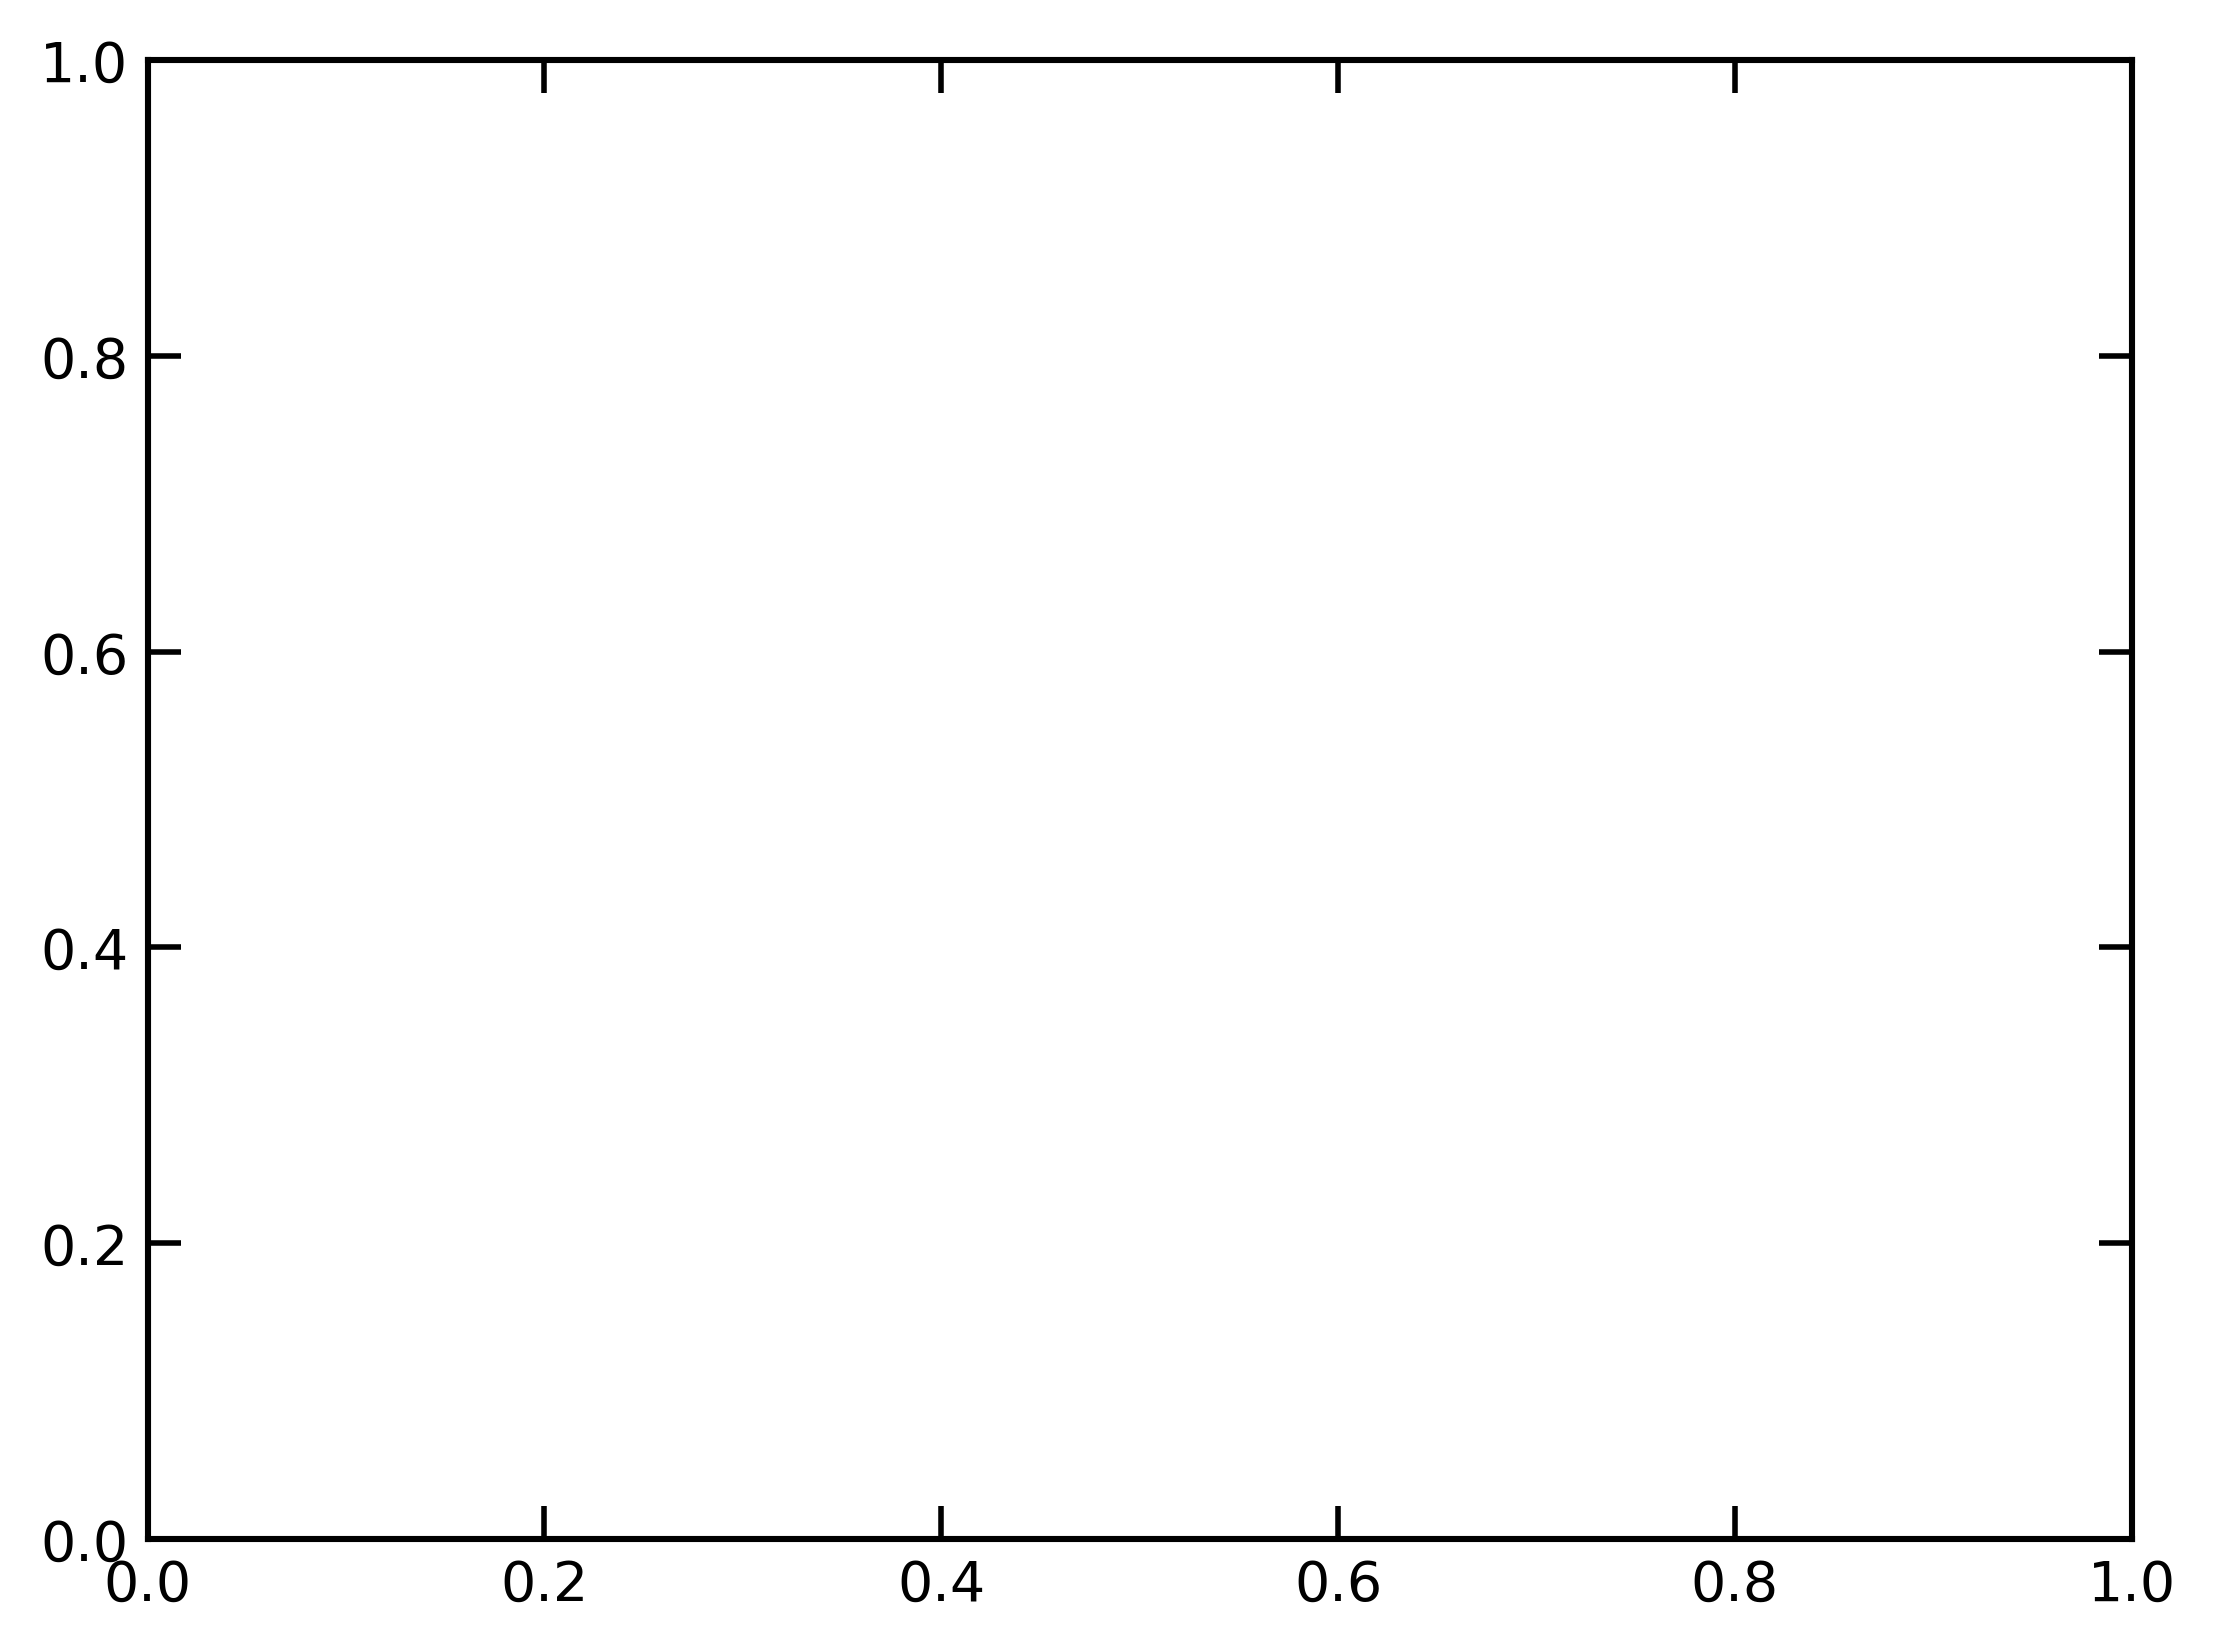

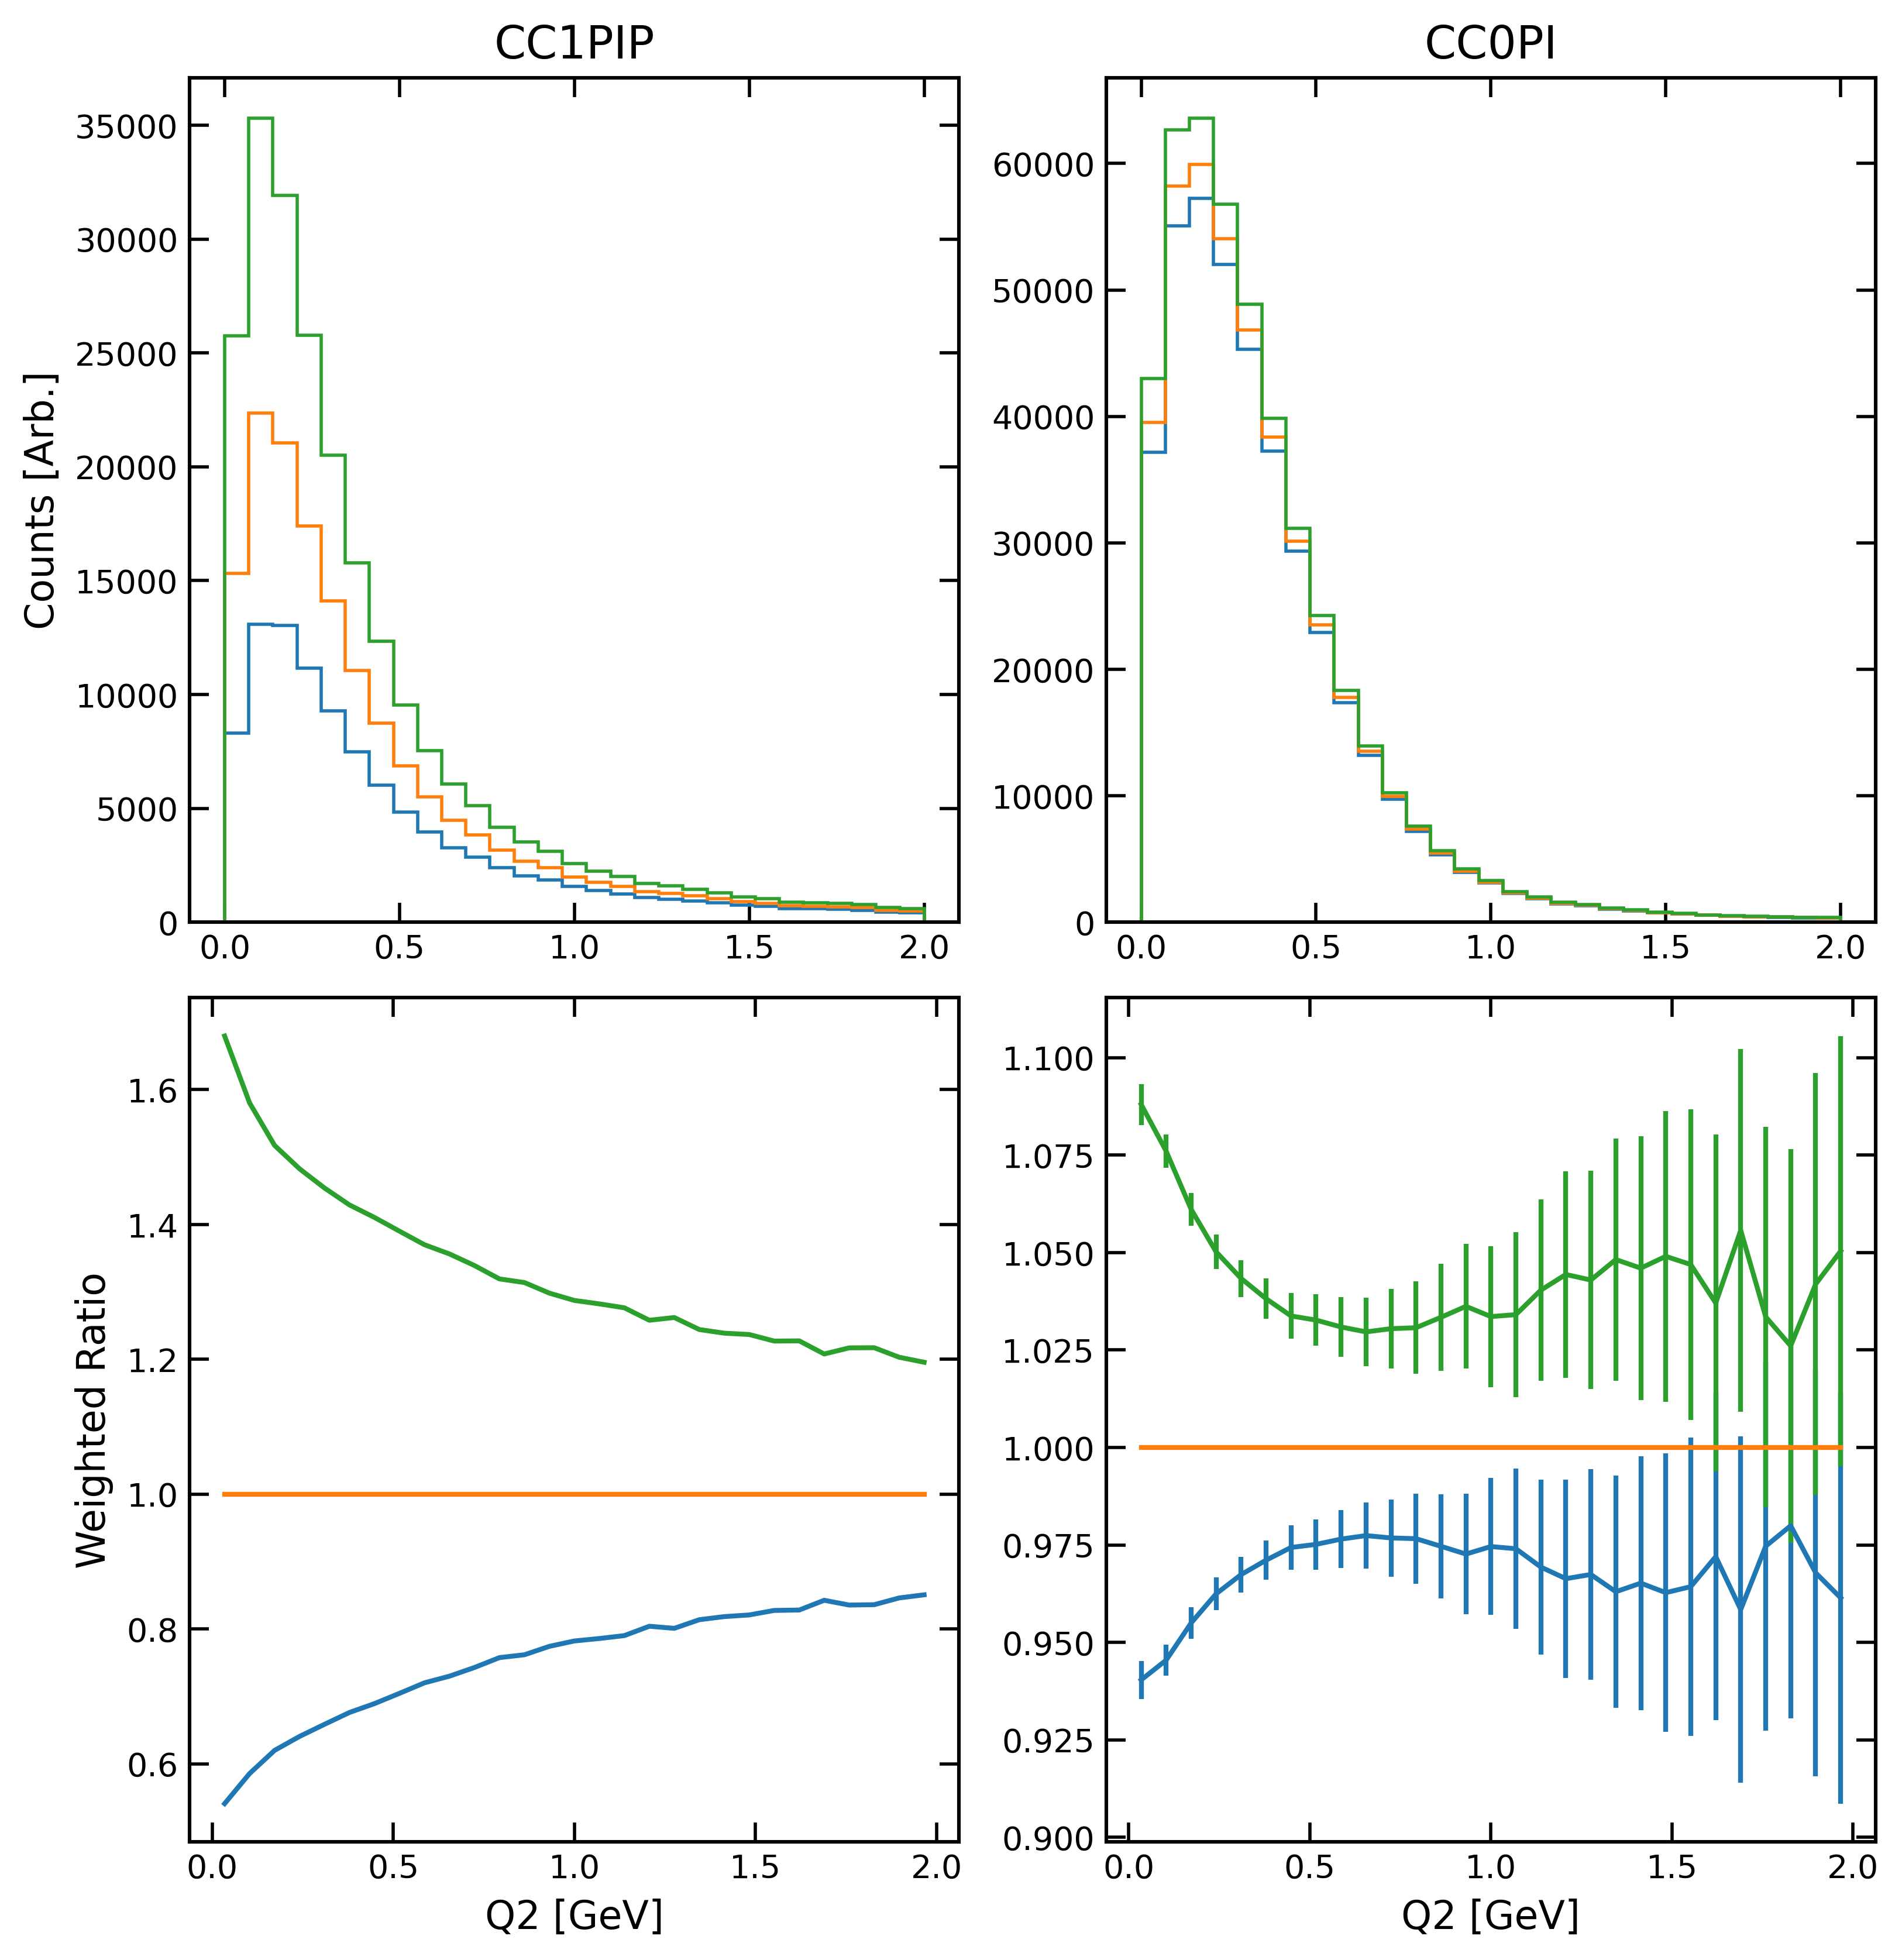

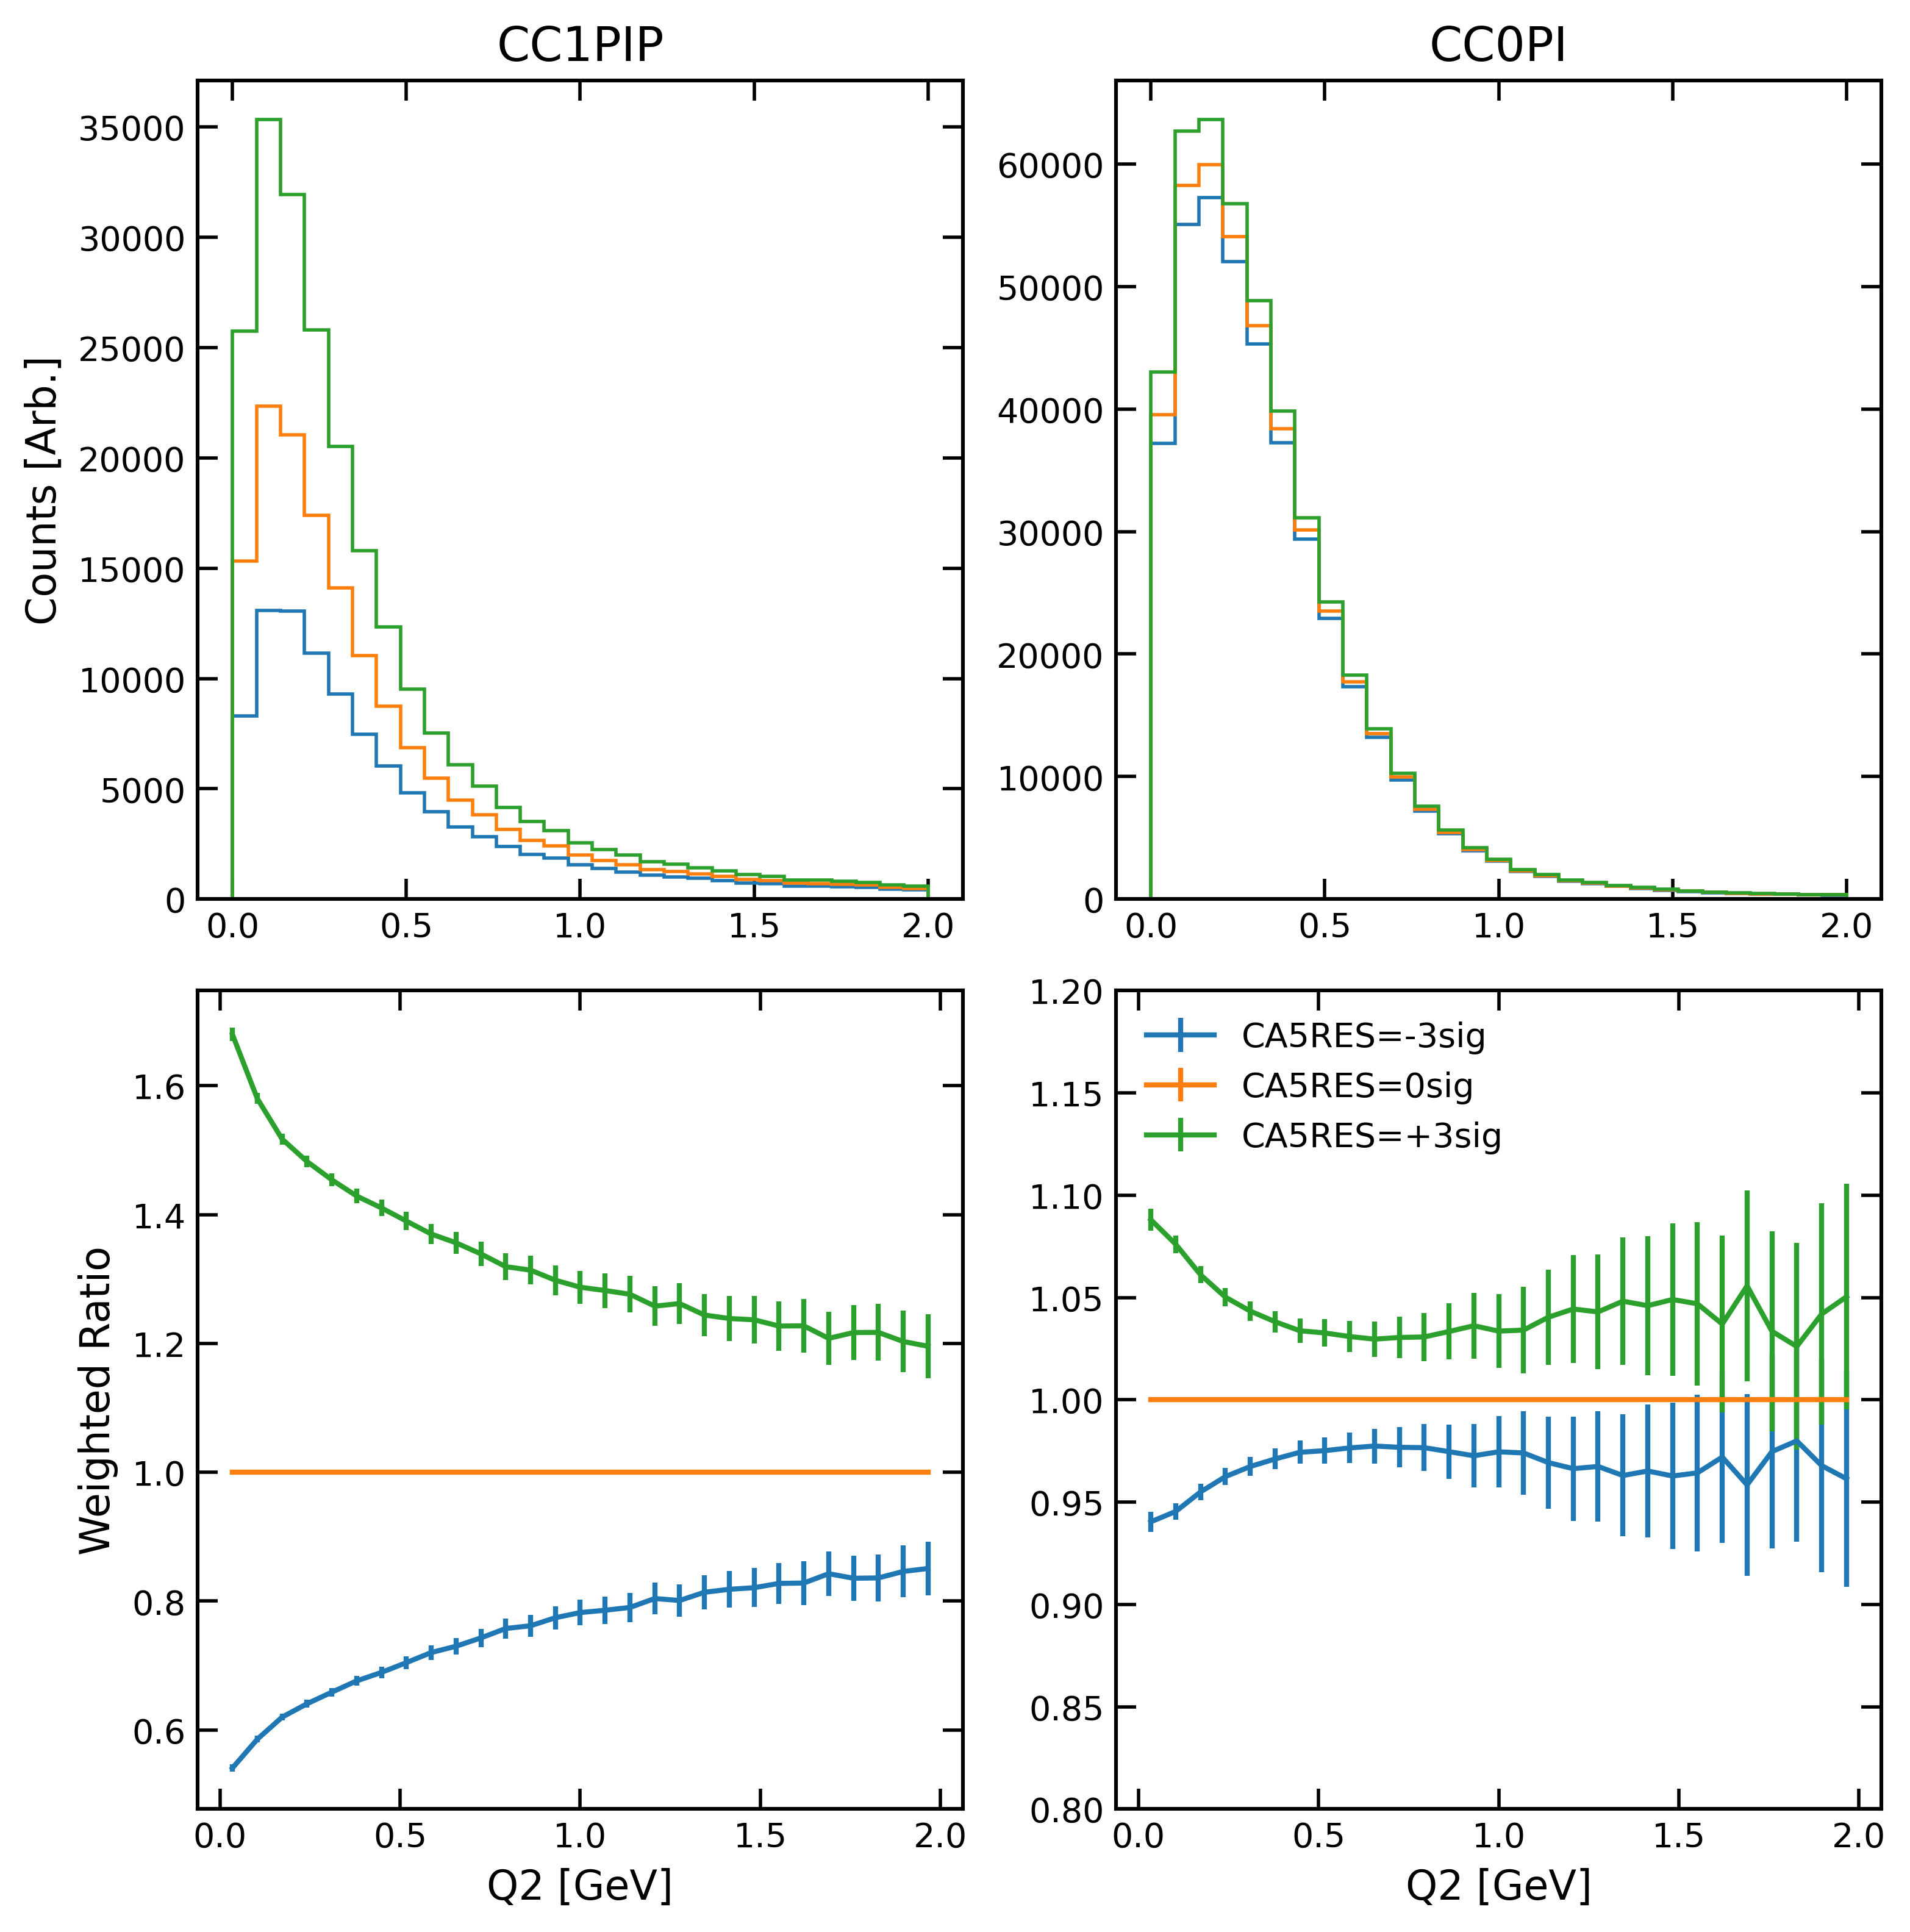

In [39]:
binning_choice = np.linspace(0,2,30)
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))


f, (ax1, ax2) = plt.subplots(2, 2, figsize=(8,8))
plt.ticklabel_format(axis='both', style='sci', scilimits=(4,4))


bv_low, bins, _ = ax1[0].hist(x=df["Q2_CC1PIP"], weights=df["CA5RES=-3.0sig"], bins=binning_choice, histtype='step')
bv_mid, bins, _ = ax1[0].hist(x=df["Q2_CC1PIP"], weights=df["CA5RES=0.0sig"], bins=binning_choice, histtype='step')
bv_hig, bins, _ = ax1[0].hist(x=df["Q2_CC1PIP"], weights=df["CA5RES=3.0sig"], bins=binning_choice, histtype='step')
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

xbins = (bins[0:-1] + bins[1:])/2
ax2[0].plot( xbins, bv_low/bv_mid )
ax2[0].plot( xbins, bv_mid/bv_mid )
ax2[0].plot( xbins, bv_hig/bv_mid )
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

bv_low, bins, _ = ax1[1].hist(x=df["Q2_CC0PI"], weights=df["CA5RES=-3.0sig"], bins=binning_choice, histtype='step')
bv_mid, bins, _ = ax1[1].hist(x=df["Q2_CC0PI"], weights=df["CA5RES=0.0sig"], bins=binning_choice, histtype='step')
bv_hig, bins, _ = ax1[1].hist(x=df["Q2_CC0PI"], weights=df["CA5RES=3.0sig"], bins=binning_choice, histtype='step')
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

xbins = (bins[0:-1] + bins[1:])/2
ax2[1].errorbar( xbins, bv_low/bv_mid, yerr=np.sqrt(bv_low)/bv_mid )
ax2[1].errorbar( xbins, bv_mid/bv_mid, yerr=0 )
ax2[1].errorbar( xbins, bv_hig/bv_mid, yerr=np.sqrt(bv_hig)/bv_mid )
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
f.tight_layout(pad=1.0)
ax1[0].set_ylabel("Counts [Arb.]")
ax2[1].set_xlabel("Q2 [GeV]")
ax2[0].set_xlabel("Q2 [GeV]")
ax2[0].set_ylabel("Weighted Ratio")
ax1[0].set_title("CC1PIP")
ax1[1].set_title("CC0PI")
plt.show()

f, (ax1, ax2) = plt.subplots(2, 2, figsize=(8,8))

bv_low, bins, _ = ax1[0].hist(x=df["Q2_CC1PIP"], weights=df["CA5RES=-3.0sig"], bins=binning_choice, histtype='step')
bv_mid, bins, _ = ax1[0].hist(x=df["Q2_CC1PIP"], weights=df["CA5RES=0.0sig"], bins=binning_choice, histtype='step')
bv_hig, bins, _ = ax1[0].hist(x=df["Q2_CC1PIP"], weights=df["CA5RES=3.0sig"], bins=binning_choice, histtype='step')

xbins = (bins[0:-1] + bins[1:])/2
ax2[0].errorbar( xbins, bv_low/bv_mid, yerr=np.sqrt(bv_low)/bv_mid )
ax2[0].errorbar( xbins, bv_mid/bv_mid, yerr=0 )
ax2[0].errorbar( xbins, bv_hig/bv_mid, yerr=np.sqrt(bv_hig)/bv_mid )

bv_low, bins, _ = ax1[1].hist(x=df["Q2_CC0PI"], weights=df["CA5RES=-3.0sig"], bins=binning_choice, histtype='step')
bv_mid, bins, _ = ax1[1].hist(x=df["Q2_CC0PI"], weights=df["CA5RES=0.0sig"], bins=binning_choice, histtype='step')
bv_hig, bins, _ = ax1[1].hist(x=df["Q2_CC0PI"], weights=df["CA5RES=3.0sig"], bins=binning_choice, histtype='step')
ax1[0].set_ylabel("Counts [Arb.]")
ax2[1].set_xlabel("Q2 [GeV]")
ax2[0].set_xlabel("Q2 [GeV]")
ax2[0].set_ylabel("Weighted Ratio")
ax1[0].set_title("CC1PIP")
ax1[1].set_title("CC0PI")

f.tight_layout(pad=1.0)

xbins = (bins[0:-1] + bins[1:])/2
ax2[1].errorbar( xbins, bv_low/bv_mid, yerr=np.sqrt(bv_low)/bv_mid, label="CA5RES=-3sig" )
ax2[1].errorbar( xbins, bv_mid/bv_mid, yerr=0, label="CA5RES=0sig" )
ax2[1].errorbar( xbins, bv_hig/bv_mid, yerr=np.sqrt(bv_hig)/bv_mid, label="CA5RES=+3sig" )
ax2[1].set_ylim([0.8,1.2])
plt.legend(loc="upper left")
plt.show()


In [9]:
!ls /Users/stowell/Downloads/T2KND*

/Users/stowell/Downloads/T2KND_FHC_numu_C8H8_NEUT562_1M_0000.root
/Users/stowell/Downloads/T2KND_FHC_numu_H2O_NUWRO_LFGRPA_1M_0000_NUISFLAT.root
/Users/stowell/Downloads/T2KND_RHC_numubar_H2O_NEUT562_1M_0001_NUISFLAT.root

/Users/stowell/Downloads/T2KND_FHC_numu_C8H8_NEUT562_1M_0001.root.download:
Info.plist
